In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import tqdm as tqdm
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [3]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True)

In [4]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [14]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


#estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
#estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]
estreams_attributes_clipped_filters = estreams_attributes_clipped

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<00:00, 398.89it/s]


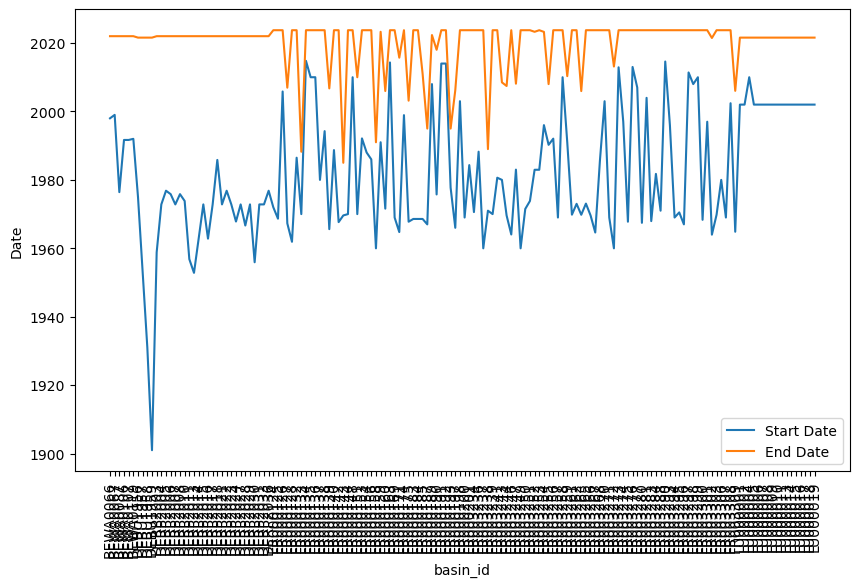

In [15]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot start_date and end_date on the same graph
estreams_attributes_clipped_filters.start_date.plot(ax=ax, label="Start Date")
estreams_attributes_clipped_filters.end_date.plot(ax=ax, label="End Date")

# Make y-axis label vertical
ax.set_ylabel("Date", rotation=90)

# Ensure ALL x-axis ticks are shown
ax.set_xticks(np.arange(len(estreams_attributes_clipped_filters)))  # Set all x-ticks
ax.set_xticklabels(estreams_attributes_clipped_filters.index, rotation=90)  # Rotate labels

# Add legend
ax.legend()

# Show plot
plt.show()


In [16]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

In [17]:
# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes.loc[catchments_ids, :]

# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

catchments_ids = estreams_attributes_clipped_sorted.index.tolist()

In [18]:
# Initialize the dictionaries
inputs = {}
observations = {}
areas = {}
perm_areas = {}
perm_areasglobal = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}

for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    data = data.loc["1988":"2001", :]
    #data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()

    data['S_dem(t-1)'] = np.nan
    data['S_dem(t)'] = np.nan

    # Initialize the first row manually
    data.iloc[0, data.columns.get_loc('S_dem(t-1)')] = 0
    data.iloc[0, data.columns.get_loc('S_dem(t)')] = max(0, data.iloc[0]['S_dem(t-1)'] + (data.iloc[0]['pet_mean'] - data.iloc[0]['p_mean']) * 1.0)

    # Compute S_dem(t-1) and S_dem(t) for the rest of the rows
    for i in range(1, len(data)):
        data.iloc[i, data.columns.get_loc('S_dem(t-1)')] = data.iloc[i-1, data.columns.get_loc('S_dem(t)')]
        data.iloc[i, data.columns.get_loc('S_dem(t)')] = max(0, data.iloc[i]['S_dem(t-1)'] + (data.iloc[i]['pet_mean'] - data.iloc[i]['p_mean']) * 1.0)
        
    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)


    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    

    perm_areasglobal[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100, 2)]
    

    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    waterdeficit_mean[basin_id] = 1.1*data["S_dem(t)"].max()


# Save the dictionaries
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

np.save(path_inputs+'\\inputs.npy', inputs)
np.save(path_inputs+'\\observations.npy', observations)
np.save(path_inputs+'\\areas.npy', areas)
np.save(path_inputs+'\\perm_areas.npy', perm_areas)
np.save(path_inputs+'\\perm_areasglobal.npy', perm_areasglobal)
np.save(path_inputs+'\\quality_masks.npy', quality_masks)
np.save(path_inputs+'\\rootdepth_mean.npy', rootdepth_mean)
np.save(path_inputs+'\\waterdeficit_mean.npy', waterdeficit_mean)

100%|██████████| 152/152 [03:16<00:00,  1.30s/it]


In [116]:
catchments_ids = first_half_df.index.tolist()
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = estreams_attributes_clipped_sorted.index.tolist()

In [71]:
catchments_ids

['DERP2017',
 'DERP2033',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [117]:
#catchments_ids = estreams_attributes_clipped_filters.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

topology_list

{'DERP2017': None,
 'DERP2033': None,
 'DERP2007': 'DEBU1958',
 'DERP2024': None,
 'FR003253': 'FR003265',
 'FR003308': 'DEBU1958',
 'FR003283': 'DEBU1958',
 'FR003301': 'DEBU1958',
 'DERP2003': 'DEBU1958',
 'FR003265': 'FR003272',
 'FR003272': 'DEBU1958',
 'DEBU1958': None}

In [118]:
import hydroanalysis

In [119]:
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}

for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()

    data['S_dem(t-1)'] = np.nan
    data['S_dem(t)'] = np.nan

    # Initialize the first row manually
    data.iloc[0, data.columns.get_loc('S_dem(t-1)')] = 0
    data.iloc[0, data.columns.get_loc('S_dem(t)')] = max(0, data.iloc[0]['S_dem(t-1)'] + (data.iloc[0]['pet_mean'] - data.iloc[0]['p_mean']) * 1.0)

    # Compute S_dem(t-1) and S_dem(t) for the rest of the rows
    for i in range(1, len(data)):
        data.iloc[i, data.columns.get_loc('S_dem(t-1)')] = data.iloc[i-1, data.columns.get_loc('S_dem(t)')]
        data.iloc[i, data.columns.get_loc('S_dem(t)')] = max(0, data.iloc[i]['S_dem(t-1)'] + (data.iloc[i]['pet_mean'] - data.iloc[i]['p_mean']) * 1.0)
        
    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)


    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    waterdeficit_mean[basin_id] = 1.1*data["S_dem(t)"].max()

100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


In [130]:
import numpy as np

# Save dictionary
np.save('dict.npy', inputs)

# Load dictionary
loaded_dict = np.load('dict.npy', allow_pickle=True).item()

print(loaded_dict)


{'DERP2017': [array([0.  , 0.  , 0.  , ..., 0.43, 0.  , 0.  ]), array([-7.25, -7.52, -5.48, ..., -4.06, -0.67,  0.1 ]), array([0.17, 0.23, 0.24, ..., 0.32, 0.26, 0.2 ])], 'DERP2033': [array([0.  , 0.  , 0.  , ..., 1.73, 0.  , 0.  ]), array([-5.  , -6.83, -4.57, ..., -2.91,  0.04,  0.39]), array([0.21, 0.22, 0.25, ..., 0.32, 0.28, 0.24])], 'DERP2007': [array([0.  , 0.  , 0.  , ..., 1.27, 0.  , 0.02]), array([-5.06, -6.27, -5.53, ..., -3.13, -0.24,  0.11]), array([0.2 , 0.26, 0.2 , ..., 0.32, 0.26, 0.24])], 'DERP2024': [array([0.  , 0.  , 0.  , ..., 1.31, 0.  , 0.02]), array([-4.93, -6.24, -5.24, ..., -3.03, -0.08,  0.34]), array([0.2 , 0.24, 0.22, ..., 0.32, 0.26, 0.23])], 'FR003253': [array([0.  , 0.  , 0.  , ..., 2.93, 0.  , 0.  ]), array([-6.3 , -5.02, -5.2 , ..., -7.74, -2.8 , -1.17]), array([0.27, 0.33, 0.29, ..., 0.24, 0.23, 0.22])], 'FR003308': [array([0., 0., 0., ..., 0., 0., 0.]), array([-6.59, -6.92, -5.01, ..., -4.5 , -0.65,  0.5 ]), array([0.16, 0.22, 0.28, ..., 0.31, 0.3 , 

In [132]:
loaded_dict["DEBU1958"]

[array([0.  , 0.  , 0.  , ..., 0.71, 0.  , 0.01]),
 array([-6.18, -6.65, -5.11, ..., -5.34, -1.24,  0.06]),
 array([0.2 , 0.26, 0.27, ..., 0.3 , 0.28, 0.22])]

In [121]:
waterdeficit_mean

{'DERP2017': 415.5690000000001,
 'DERP2033': 777.2490000000006,
 'DERP2007': 464.25500000000017,
 'DERP2024': 442.1559999999999,
 'FR003253': 514.316,
 'FR003308': 1957.416999999997,
 'FR003283': 1422.8720000000046,
 'FR003301': 934.5820000000006,
 'DERP2003': 528.8579999999996,
 'FR003265': 553.0250000000001,
 'FR003272': 572.7040000000003,
 'DEBU1958': 648.9009999999997}

In [244]:
# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}

for basin_id in catchments_ids:
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    #data = data.loc["1988":"2001", :]
    data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100, 2)]
    quality_masks[basin_id] = quality

In [122]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [123]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

In [124]:
import numba as nb
from superflexpy.framework.element import ODEsElement
from copy import deepcopy
import numba as nb
from superflexpy.framework.element import ODEsElement
from copy import deepcopy

class CustomUnsaturatedReservoir(UnsaturatedReservoir):
    """
    This class implements the UnsaturatedReservoir of HBV.
    """

    def __init__(self, parameters, states, approximation, id):
        
        """
        This is the initializer of the class UnsaturatedReservoir.

        Parameters
        ----------
        parameters : dict
            Parameters of the element. The keys must be:
            'Smax' : maximum reservoir storage
            'Ce' : Potential evapotranspiration multiplier
            'm' : Smoothing factor for evapotranspiration
            'beta' : Exponent in the relation for the streamflow
        states : dict
            Initial state of the element. The keys must be:
            - 'S0' : initial storage of the reservoir.
        approximation : superflexpy.utils.numerical_approximation.NumericalApproximator
            Numerial method used to approximate the differential equation
        id : str
            Itentifier of the element. All the elements of the framework must
            have an id.
        """

        ODEsElement.__init__(self, parameters=parameters, states=states, approximation=approximation, id=id)

        self._fluxes_python = [self._fluxes_function_python]

        if approximation.architecture == "numba":
            self._fluxes = [self._fluxes_function_numba]
        elif approximation.architecture == "python":
            self._fluxes = [self._fluxes_function_python]


    # METHODS FOR THE USER

    def set_input(self, input):
        """
        Set the input of the element.

        Parameters
        ----------
        input : list(numpy.ndarray)
            List containing the input fluxes of the element. It contains 2
            fluxes:
            1. Rainfall
            2. PET
        """

        self.input = {"P": input[0], "PET": input[1]}

    def get_output(self, solve=True):
        """
        This method solves the differential equation governing the routing
        store.

        Returns
        -------
        list(numpy.ndarray)
            Output fluxes in the following order:
            1. Streamflow (Q)
        """

        if solve:
            self._solver_states = [self._states[self._prefix_states + "S0"]]

            self._solve_differential_equation()

            # Update the state
            self.set_states({self._prefix_states + "S0": self.state_array[-1, 0]})

        fluxes = self._num_app.get_fluxes(
            fluxes=self._fluxes_python,
            S=self.state_array,
            S0=self._solver_states,
            dt=self._dt,
            **self.input,
            **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
        )

        return [-fluxes[0][2]]

    def get_AET(self):
        """
        This method calculates the actual evapotranspiration

        Returns
        -------
        numpy.ndarray
            Array of actual evapotranspiration
        """

        try:
            S = self.state_array
        except AttributeError:
            message = "{}get_aet method has to be run after running ".format(self._error_message)
            message += "the model using the method get_output"
            raise AttributeError(message)

        fluxes = self._num_app.get_fluxes(
            fluxes=self._fluxes_python,
            S=S,
            S0=self._solver_states,
            dt=self._dt,
            **self.input,
            **{k[len(self._prefix_parameters) :]: self._parameters[k] for k in self._parameters},
        )

        return [-fluxes[0][1]]

    # PROTECTED METHODS

    @staticmethod
    def _fluxes_function_python(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
        # TODO: handle time variable parameters (Smax) -> overflow
        Smax = Csmax * bacon

        if ind is None:
            return (
                [
                    P,
                    -Ce * PET * ((S / Smax) * (1 + m)) / ((S / Smax) + m),
                    -P * (S / Smax) ** beta,
                ],
                0.0,
                S0 + P * dt,
            )
        else:
            Smax[ind] = Csmax[ind] * bacon[ind]

            return (
                [
                    P[ind],
                    -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                    -P[ind] * (S / Smax[ind]) ** beta[ind],
                ],
                0.0,
                S0 + P[ind] * dt[ind],
                [
                    0.0,
                    -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                    -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
                ],
            )

    @staticmethod
    @nb.jit(
        "Tuple((UniTuple(f8, 3), f8, f8,UniTuple(f8, 3)))"
        "(optional(f8), f8, i4, f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:], f8[:])",
        nopython=True,
    )
    def _fluxes_function_numba(S, S0, ind, P, Csmax, Ce, m, bacon, beta, PET, dt):
        # TODO: handle time variable parameters (Smax) -> overflow
        Smax = Csmax * bacon
        
        return (
            (
                P[ind],
                -Ce[ind] * PET[ind] * ((S / Smax[ind]) * (1 + m[ind])) / ((S / Smax[ind]) + m[ind]),
                -P[ind] * (S / Smax[ind]) ** beta[ind],
            ),
            0.0,
            S0 + P[ind] * dt[ind],
            (
                0.0,
                -(Ce[ind] * PET[ind] * m[ind] * (m[ind] + 1) * Smax[ind]) / ((S + m[ind] * Smax[ind]) ** 2),
                -(P[ind] * beta[ind] / Smax[ind]) * (S / Smax[ind]) ** (beta[ind] - 1),
            ),
        )

In [125]:
# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:


    unsaturated = CustomUnsaturatedReservoir(
        parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean[cat_id]},
        states={'S0': 10.0},
        approximation=num_app,
        id='unsaturated')


    general = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='general'
    )

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low'
    )

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high'
    )

    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    
    node.set_input(inputs[cat_id])  # Correct way to set inputs
    
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    #globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)



In [33]:
print(dir(model))  # List all available attributes and methods

['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_network', '_content', '_content_pointer', '_downstream', '_error_message', '_find_attribute_from_name', '_find_content_from_name', '_headwater', '_init_local_states', '_local_parameters', '_local_states', '_prefix_local_parameters', '_prefix_local_states', '_total_area', '_upstream', 'call_internal', 'define_solver', 'get_internal', 'get_output', 'get_parameters', 'get_parameters_name', 'get_states', 'get_states_name', 'get_timestep', 'reset_states', 'set_parameters', 'set_states', 'set_timestep']


In [127]:
def assign_parameter_values(parameters_name_model, parameter_names, parameters):
    """
    Assigns values from `parameters` to `parameters_name_model` where a match exists in `parameter_names`,
    but keeps any parameters that have three segments (`X_Y_Z`) unchanged.

    Args:
        parameters_name_model (list): List of full parameter names (e.g., "general_slow_k").
        parameter_names (list): List of unique parameter names (e.g., "slow_k", "high_slow_k").
        parameters (list): List of values corresponding to `parameter_names`.

    Returns:
        dict: Dictionary {parameter_name_model: assigned_value}, where:
            - `X_Y` parameters are updated from `parameter_names`.
            - `X_Y_Z` parameters are kept unchanged.
    """
    # Create a dictionary mapping parameter_names to their corresponding values
    param_value_dict = {param_name: value for param_name, value in zip(parameter_names, parameters)}

    # Build the output dictionary
    filtered_parameters = {}

    for param_name in parameters_name_model:
        parts = param_name.split("_")  # Split the name to check structure
        base_name = "_".join(parts[-2:])  # Extract last two parts (X_Y)
        
        if base_name in param_value_dict:  # If X_Y is in parameter_names
            filtered_parameters[param_name] = param_value_dict[base_name]
        elif param_name in parameter_names:  # Direct match in parameter_names (X_Y)
            filtered_parameters[param_name] = param_value_dict[param_name]
    
    return filtered_parameters  # Return dictionary of matched parameters


class spotpy_model(object):

    def __init__(self, model, catchments, dt, observations, parameters, parameter_names, parameter_names_model, output_index, warm_up=365):

        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            model (Network): SuperflexPy network containing multiple nodes.
            catchments (list): List of Node objects.
            inputs (dict): Dictionary with inputs for each node.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._model = model  # The SuperflexPy network
        self._catchments = catchments  # List of catchments
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names
        self._parameter_names_model = parameter_names_model  # Store full parameter names

        # Store inputs and observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the entire network using the same parameter set and collects per-node outputs."""

        # Convert parameter list into a dictionary
        #named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
        
        # Check if parameters have changed (avoid unnecessary computations)
        if not hasattr(self, "_cached_params") or not np.array_equal(self._cached_params, parameters):
            self._cached_params = np.array(parameters)  # Store the current parameters
            named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
            self._model.set_parameters(named_parameters)  # Apply shared parameters

        # Apply shared parameters to the whole network (this is due to the way we set Csumax)
        for key in model._content_pointer.keys():
            i = model._content_pointer[key] 
            self._model._content[i].set_parameters(named_parameters)
        #self._model.set_parameters(named_parameters)

        # Set timestep and reset the network
        self._model.set_timestep(self._dt)
        self._model.reset_states()

        # Run the full network
        output = self._model.get_output()  # Get outputs for all nodes

        # Return outputs as a list (one per node)
        return [output[cat.id][self._output_index] for cat in self._catchments]

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for sim, cat in zip(simulation, self._catchments):
            node_id = cat.id
            obs = evaluation[node_id]

            # Apply warm-up period
            sim = sim[self._warm_up + 1:]
            obs = obs[self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error

In [113]:
model.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=model,  # The entire SuperflexPy network
    catchments=catchments,  # Use predefined catchments list
    dt=1.0,  # Time step
    observations=observations,  # Observed data per node
    parameters=[
        spotpy.parameter.Uniform("general_fast_k", 0.0001, 1.0), #1e-5, 1.0
        spotpy.parameter.Uniform("low_fast_k", 0.0001, 1.0),

        spotpy.parameter.Uniform("high_slowhigh_k", 1e-7, 0.1),
        spotpy.parameter.Uniform("general_slow_k", 1e-7, 0.1),

        spotpy.parameter.Uniform("unsaturated_Ce", 0.1, 3.0),
        spotpy.parameter.Uniform("unsaturated_Csmax", 0.1, 5.0),  # Global calibration parameter

        spotpy.parameter.Uniform("snow_k", 0.01, 10.0),
        #spotpy.parameter.Uniform("unsaturated_Smax", 50.0, 600.0),
        #spotpy.parameter.Uniform("splitpar", 0.5, 0.9),

        
        spotpy.parameter.Uniform("unsaturated_beta", 0.01, 10.0),
        spotpy.parameter.Uniform("general_lag-fun_lag-time", 1.0, 10.0),
    ],
    parameter_names=[
        "general_fast_k", "low_fast_k", 
        "high_slowhigh_k", "general_slow_k", "unsaturated_Ce", "unsaturated_Csmax", "snow_k", 
        "unsaturated_beta", "general_lag-fun_lag-time",
    ],
    parameter_names_model = model.get_parameters_name(),
    output_index=0,  # Assumes all nodes have the same output variable
    warm_up=365,  # Warm-up period
)

#parameter_names_model = model.get_parameters_name()

In [84]:
#sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname='calibration', dbformat="csv", parallel="seq")

sampler.sample(repetitions=500)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  500  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 500, minimal objective function=4.98067, time remaining: 00:14:56
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calibration.csv' created.
2 of 500, minimal objective function=4.4231, time remaining: 00:20:45
3 of 500, minimal objective function=1.28688, time remaining: 00:25:51
4 of 500, minimal objective function=1.28688, time remaining: 00:28:17
5 of 500, minimal objective function=1.28688, time remaining: 00:30:35
6 of 500, minimal objective function=1.28688, time remaining: 00:31:02
7 of 500, minimal objective function=1.28688, time remaining: 00:32:08
8 of 500, minimal objective function=1.28688, time remaining: 00:32:54
9 of 500, minimal objective function=0.695681, time remaining: 00:33:59
10 of 500, minimal objective function=0.695681, time remaining: 00:34:29
11 of 500, min

In [39]:
## Load the CSV file
results_df = pd.read_csv("calibration.csv")

# Convert to a NumPy structured array (similar to `sampler.getdata()`)
results = results_df.to_records(index=False)

The figure as been saved as "Parameter_trace.png
Run number 234 has the lowest objectivefunction with: 0.595


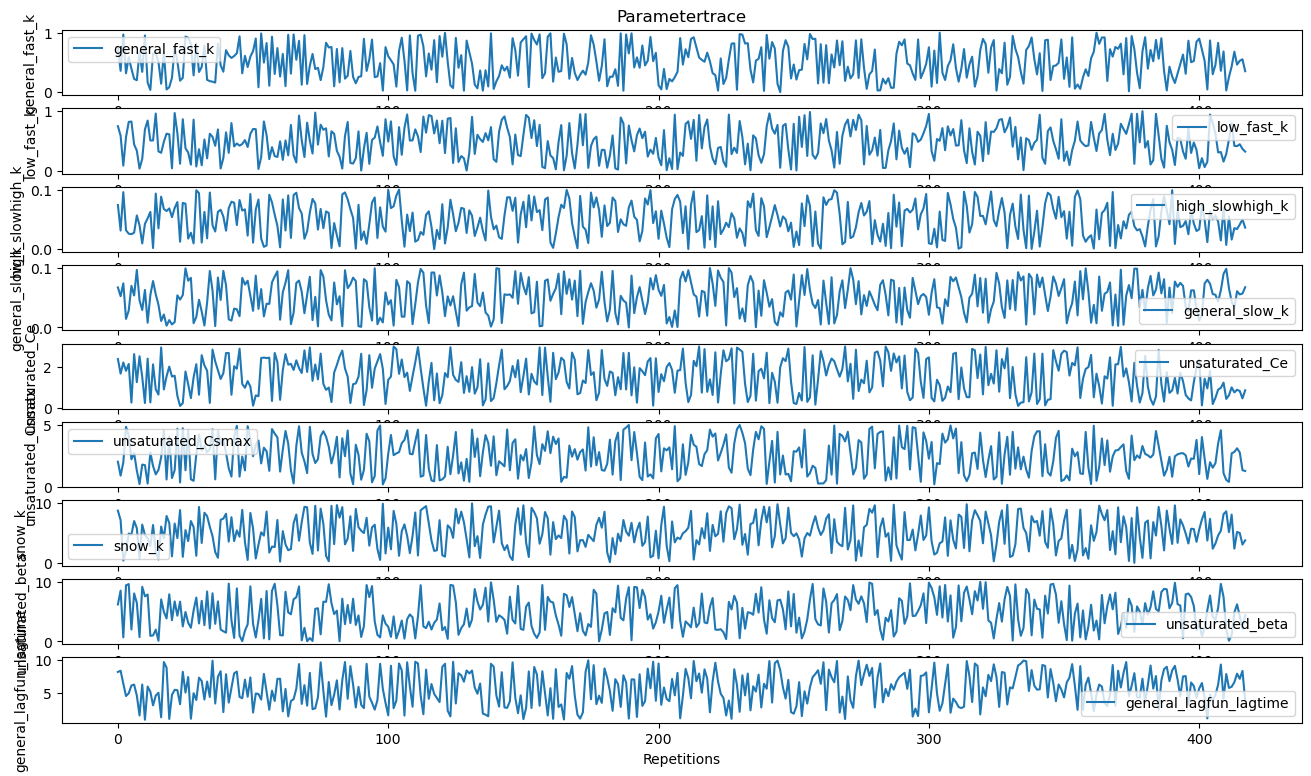

In [85]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function


spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))



In [86]:
if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'general_lagfun_lagtime' in best_params_dict:
    best_params_dict['general_lag-fun_lag-time'] = best_params_dict.pop('general_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

In [87]:
best_params_dict

{'general_fast_k': 0.37882286,
 'low_fast_k': 0.0103636375,
 'high_slowhigh_k': 0.06994202,
 'general_slow_k': 0.086504795,
 'unsaturated_Ce': 0.59351796,
 'unsaturated_Csmax': 0.92475754,
 'snow_k': 6.461477,
 'unsaturated_beta': 4.799321,
 'general_lag-fun_lag-time': 2.415295}

In [89]:
model._content[3].get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 3.6311758428245424,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 1.842888188991743,
 'high_unsaturated_Ce': 0.8624384219039185,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 3.3671839405990873,
 'high_unsaturated_bacon': 442.1559999999999,
 'high_slowhigh_k': 0.05529828768734095,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 3.6311758428245424,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 1.842888188991743,
 'general_unsaturated_Ce': 0.8624384219039185,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 3.3671839405990873,
 'general_unsaturated_bacon': 442.1559999999999,
 'general_lowersplitter_splitpar': 0.5,
 'general_slow_k': 0.05337341122906214,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 4.690179828668809,
 'general_fast_k': 0.3748445358535636,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 3.6311758428245424,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 1

In [79]:
parameter_names = list(best_params_dict.keys())
parameter_names

['general_fast_k',
 'low_fast_k',
 'high_slowhigh_k',
 'general_slow_k',
 'unsaturated_Ce',
 'unsaturated_Csmax',
 'snow_k',
 'unsaturated_beta',
 'lagfun_lagtime']

In [75]:
parameters = list(best_params_dict.values())
parameters

[0.35103032,
 0.42820302,
 0.08195218,
 0.09202246,
 1.7186983,
 1.2823069,
 3.6496751,
 0.9115352,
 2.6844864]

In [47]:
parameter_names_model = model.get_parameters_name()
parameter_names_model

['high_snow_t0',
 'high_snow_k',
 'high_snow_m',
 'high_unsaturated_Csmax',
 'high_unsaturated_Ce',
 'high_unsaturated_m',
 'high_unsaturated_beta',
 'high_unsaturated_bacon',
 'high_slowhigh_k',
 'high_slowhigh_alpha',
 'general_snow_t0',
 'general_snow_k',
 'general_snow_m',
 'general_unsaturated_Csmax',
 'general_unsaturated_Ce',
 'general_unsaturated_m',
 'general_unsaturated_beta',
 'general_unsaturated_bacon',
 'general_lowersplitter_splitpar',
 'general_slow_k',
 'general_slow_alpha',
 'general_lag-fun_lag-time',
 'general_fast_k',
 'general_fast_alpha',
 'low_snow_t0',
 'low_snow_k',
 'low_snow_m',
 'low_unsaturated_Csmax',
 'low_unsaturated_Ce',
 'low_unsaturated_m',
 'low_unsaturated_beta',
 'low_unsaturated_bacon',
 'low_fast_k',
 'low_fast_alpha']

In [48]:
model.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 7.7187148807874735,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 3.841424781650864,
 'high_unsaturated_Ce': 2.2579308492438925,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 4.733015360337484,
 'high_unsaturated_bacon': 103.786,
 'high_slowhigh_k': 0.04436197466334521,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 7.7187148807874735,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 3.841424781650864,
 'general_unsaturated_Ce': 2.2579308492438925,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 4.733015360337484,
 'general_unsaturated_bacon': 103.786,
 'general_lowersplitter_splitpar': 0.5,
 'general_slow_k': 0.0675633007149089,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 5.24358733866226,
 'general_fast_k': 0.16004765787457914,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 7.7187148807874735,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 3.841424781650864,
 'low

In [ ]:
model.get_internal(id="")

TypeError: Network.get_internal() missing 2 required positional arguments: 'id' and 'attribute'

In [121]:
FR003253.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 0.01,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 2.0,
 'high_unsaturated_Ce': 1.0,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 2.0,
 'high_unsaturated_bacon': 104.727,
 'high_slowhigh_k': 0.0001,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 0.01,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 2.0,
 'general_unsaturated_Ce': 1.0,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 2.0,
 'general_unsaturated_bacon': 104.727,
 'general_lowersplitter_splitpar': 0.5,
 'general_slow_k': 0.0001,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 4.0,
 'general_fast_k': 0.01,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 0.01,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 2.0,
 'low_unsaturated_Ce': 1.0,
 'low_unsaturated_m': 0.01,
 'low_unsaturated_beta': 2.0,
 'low_unsaturated_bacon': 104.727,
 'low_fast_k': 0.01,
 'low_fast_alpha': 2.0}

In [120]:
DEBU1958.get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 0.01,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 2.0,
 'high_unsaturated_Ce': 1.0,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 2.0,
 'high_unsaturated_bacon': 110.673,
 'high_slowhigh_k': 0.0001,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 0.01,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 2.0,
 'general_unsaturated_Ce': 1.0,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 2.0,
 'general_unsaturated_bacon': 110.673,
 'general_lowersplitter_splitpar': 0.5,
 'general_slow_k': 0.0001,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 4.0,
 'general_fast_k': 0.01,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 0.01,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 2.0,
 'low_unsaturated_Ce': 1.0,
 'low_unsaturated_m': 0.01,
 'low_unsaturated_beta': 2.0,
 'low_unsaturated_bacon': 110.673,
 'low_fast_k': 0.01,
 'low_fast_alpha': 2.0}

In [49]:
assign_parameter_values(parameter_names_model, parameter_names, parameters, rootdepth_mean)

TypeError: assign_parameter_values() takes 3 positional arguments but 4 were given

In [90]:
parameter_names = list(best_params_dict.keys())
parameters = list(best_params_dict.values())
parameter_names_model = model.get_parameters_name()
best_params_dict_model = assign_parameter_values(parameter_names_model, parameter_names, parameters)
best_params_dict_model

{'high_snow_k': 6.461477,
 'high_unsaturated_Csmax': 0.92475754,
 'high_unsaturated_Ce': 0.59351796,
 'high_unsaturated_beta': 4.799321,
 'high_slowhigh_k': 0.06994202,
 'general_snow_k': 6.461477,
 'general_unsaturated_Csmax': 0.92475754,
 'general_unsaturated_Ce': 0.59351796,
 'general_unsaturated_beta': 4.799321,
 'general_slow_k': 0.086504795,
 'general_lag-fun_lag-time': 2.415295,
 'general_fast_k': 0.37882286,
 'low_snow_k': 6.461477,
 'low_unsaturated_Csmax': 0.92475754,
 'low_unsaturated_Ce': 0.59351796,
 'low_unsaturated_beta': 4.799321,
 'low_fast_k': 0.0103636375}

In [68]:
parameter_names

['general_fast_k',
 'low_fast_k',
 'high_slowhigh_k',
 'general_slow_k',
 'unsaturated_Ce',
 'unsaturated_Csmax',
 'snow_k',
 'unsaturated_beta',
 'lagfun_lagtime']

In [69]:
parameter_names

['general_fast_k',
 'low_fast_k',
 'high_slowhigh_k',
 'general_slow_k',
 'unsaturated_Ce',
 'unsaturated_Csmax',
 'snow_k',
 'unsaturated_beta',
 'lagfun_lagtime']

In [ ]:
best_params_dict_model_r_2 = {'high_snow_k': 3.223206152171025,
 'high_unsaturated_Ce': 1.276036499733342,
 'high_unsaturated_beta': 0.6272350895212931,
 'high_slowhigh_k': 0.005012661631998021,
 'general_snow_k': 3.223206152171025,
 'general_unsaturated_Ce': 1.276036499733342,
 'general_unsaturated_beta': 0.6272350895212931,
 'general_slow_k': 0.030264868926374384,
 'general_lag-fun_lag-time': 4.3269007027127095,
 'general_fast_k': 0.8386000893514057,
 'low_snow_k': 3.223206152171025,
 'low_unsaturated_Ce': 1.276036499733342,
 'low_unsaturated_beta': 0.6272350895212931,
 'low_fast_k': 0.012417789198374168}

In [86]:
best_params_dict_model_g_2 = {'high_snow_k': 5.359145874384727,
 'high_unsaturated_Smax': 182.50922616599593,
 'high_unsaturated_Ce': 0.7809191244600945,
 'high_unsaturated_beta': 1.114514511106531,
 'high_slowhigh_k': 0.012547216580619927,
 'general_snow_k': 5.359145874384727,
 'general_unsaturated_Smax': 182.50922616599593,
 'general_unsaturated_Ce': 0.7809191244600945,
 'general_unsaturated_beta': 1.114514511106531,
 'general_slow_k': 0.04812496698789066,
 'general_lag-fun_lag-time': 7.217944361063212,
 'general_fast_k': 0.5456109363213215,
 'low_snow_k': 5.359145874384727,
 'low_unsaturated_Smax': 182.50922616599593,
 'low_unsaturated_Ce': 0.7809191244600945,
 'low_unsaturated_beta': 1.114514511106531,
 'low_fast_k': 0.35519349408256895}

In [34]:
best_params_dict_model_r_1 = {'high_snow_k': 4.086426297944429,
 'high_unsaturated_Ce': 0.9567288089362507,
 'high_unsaturated_beta': 1.0331337523819135,
 'high_slowhigh_k': 0.0013319218103794586,
 'general_snow_k': 4.086426297944429,
 'general_unsaturated_Ce': 0.9567288089362507,
 'general_unsaturated_beta': 1.0331337523819135,
 'general_slow_k': 0.011234798028853129,
 'general_lag-fun_lag-time': 3.9750011064022424,
 'general_fast_k': 0.48590540089635903,
 'low_snow_k': 4.086426297944429,
 'low_unsaturated_Ce': 0.9567288089362507,
 'low_unsaturated_beta': 1.0331337523819135,
 'low_fast_k': 0.004905033249936297}

In [86]:
best_params_dict_model_g_1 = {'high_snow_k': 4.196749756267835,
 'high_unsaturated_Ce': 0.8669048058401205,
 'high_unsaturated_beta': 0.8923904812427841,
 'high_slowhigh_k': 0.0009871387474522922,
 'general_snow_k': 4.196749756267835,
 'general_unsaturated_Ce': 0.8669048058401205,
 'general_unsaturated_beta': 0.8923904812427841,
 'general_slow_k': 0.024640353857886783,
 'general_lag-fun_lag-time': 3.175523750291455,
 'general_fast_k': 0.25928255610147044,
 'low_snow_k': 4.196749756267835,
 'low_unsaturated_Ce': 0.8669048058401205,
 'low_unsaturated_beta': 0.8923904812427841,
 'low_fast_k': 0.16955621942568638}

In [48]:
best_params_dict_model_r_1_sumaxroot = {'high_snow_k': 2.8412905,
 'high_unsaturated_Csmax': 1.163273,
 'high_unsaturated_Ce': 0.8445858,
 'high_unsaturated_beta': 1.0812291,
 'high_slowhigh_k': 0.00017900385,
 'general_snow_k': 2.8412905,
 'general_unsaturated_Csmax': 1.163273,
 'general_unsaturated_Ce': 0.8445858,
 'general_unsaturated_beta': 1.0812291,
 'general_slow_k': 0.04970295,
 'general_lag-fun_lag-time': 3.0440333,
 'general_fast_k': 0.17113046,
 'low_snow_k': 2.8412905,
 'low_unsaturated_Csmax': 1.163273,
 'low_unsaturated_Ce': 0.8445858,
 'low_unsaturated_beta': 1.0812291,
 'low_fast_k': 0.0048160907}

In [47]:
perm_areas

{'DERP2017': [0.25, 0.26, 0.49],
 'DERP2033': [0.11, 0.49, 0.4],
 'DERP2007': [0.16, 0.19, 0.65],
 'DERP2024': [0.37, 0.28, 0.35],
 'FR003253': [0.59, 0.06, 0.35],
 'FR003308': [0.07, 0.93, 0.0],
 'FR003283': [0.0, 1.0, 0.0],
 'FR003301': [0.17, 0.83, 0.0],
 'DERP2003': [0.17, 0.3, 0.53],
 'FR003265': [0.29, 0.53, 0.18],
 'FR003272': [0.24, 0.63, 0.13],
 'DEBU1958': [0.25, 0.6, 0.15]}

In [319]:
best_params_dict_model_global_first = {'high_snow_k': 8.611834,
 'high_unsaturated_Smax': 143.17062,
 'high_unsaturated_Ce': 0.6780115,
 'high_unsaturated_beta': 1.5223864,
 'high_slowhigh_k': 0.0037658303,
 'general_snow_k': 8.611834,
 'general_unsaturated_Smax': 143.17062,
 'general_unsaturated_Ce': 0.6780115,
 'general_unsaturated_beta': 1.5223864,
 'general_slow_k': 0.019432535,
 'general_fast_k': 0.14031577,
 'low_snow_k': 8.611834,
 'low_unsaturated_Smax': 143.17062,
 'low_unsaturated_Ce': 0.6780115,
 'low_unsaturated_beta': 1.5223864,
 'low_fast_k': 0.85006255}

In [111]:
best_params_dict_model = {'high_snow_k': 4.086426297944429,
 'high_unsaturated_Csmax': 1.5,
 'high_unsaturated_Ce': 0.9567288089362507,
 'high_unsaturated_beta': 1.0331337523819135,
 'high_slowhigh_k': 0.0013319218103794586,
 'general_snow_k': 4.086426297944429,
  'general_unsaturated_Csmax': 1.5,
 'general_unsaturated_Ce': 0.9567288089362507,
 'general_unsaturated_beta': 1.0331337523819135,
 'general_slow_k': 0.011234798028853129,
 'general_lag-fun_lag-time': 3.9750011064022424,
 'general_fast_k': 0.48590540089635903,
 'low_snow_k': 4.086426297944429,
'low_unsaturated_Csmax': 1.5,
 'low_unsaturated_Ce': 0.9567288089362507,
 'low_unsaturated_beta': 1.0331337523819135,
 'low_fast_k': 0.004905033249936297}

In [111]:
best_params_dict_model

{'high_snow_k': 6.461477,
 'high_unsaturated_Csmax': 0.92475754,
 'high_unsaturated_Ce': 0.59351796,
 'high_unsaturated_beta': 4.799321,
 'high_slowhigh_k': 0.06994202,
 'general_snow_k': 6.461477,
 'general_unsaturated_Csmax': 0.92475754,
 'general_unsaturated_Ce': 0.59351796,
 'general_unsaturated_beta': 4.799321,
 'general_slow_k': 0.086504795,
 'general_lag-fun_lag-time': 2.415295,
 'general_fast_k': 0.37882286,
 'low_snow_k': 6.461477,
 'low_unsaturated_Csmax': 0.92475754,
 'low_unsaturated_Ce': 0.59351796,
 'low_unsaturated_beta': 4.799321,
 'low_fast_k': 0.0103636375}

In [ ]:
model.reset_states()
#for cat in catchments:
#    cat.set_input(inputs[cat.id])  # Correct way to set inputs

for key in model._content_pointer.keys():
    i = model._content_pointer[key] 
    model._content[i].set_parameters(best_params_dict_model)

model.set_timestep(1.0)

#model.set_parameters(best_params_dict_model)


In [98]:
model._content[4].get_parameters()

{'high_snow_t0': 0.0,
 'high_snow_k': 6.461477,
 'high_snow_m': 2.0,
 'high_unsaturated_Csmax': 0.92475754,
 'high_unsaturated_Ce': 0.59351796,
 'high_unsaturated_m': 0.01,
 'high_unsaturated_beta': 4.799321,
 'high_unsaturated_bacon': 514.316,
 'high_slowhigh_k': 0.06994202,
 'high_slowhigh_alpha': 2.0,
 'general_snow_t0': 0.0,
 'general_snow_k': 6.461477,
 'general_snow_m': 2.0,
 'general_unsaturated_Csmax': 0.92475754,
 'general_unsaturated_Ce': 0.59351796,
 'general_unsaturated_m': 0.01,
 'general_unsaturated_beta': 4.799321,
 'general_unsaturated_bacon': 514.316,
 'general_lowersplitter_splitpar': 0.5,
 'general_slow_k': 0.086504795,
 'general_slow_alpha': 1.0,
 'general_lag-fun_lag-time': 2.415295,
 'general_fast_k': 0.37882286,
 'general_fast_alpha': 2.0,
 'low_snow_t0': 0.0,
 'low_snow_k': 6.461477,
 'low_snow_m': 2.0,
 'low_unsaturated_Csmax': 0.92475754,
 'low_unsaturated_Ce': 0.59351796,
 'low_unsaturated_m': 0.01,
 'low_unsaturated_beta': 4.799321,
 'low_unsaturated_bacon':

In [92]:

#hyd_mod.reset_states()
output = model.get_output()
output

{'DERP2017': [array([0.        , 0.        , 0.        , ..., 1.25639245, 1.00325175,
         0.92364168])],
 'DERP2033': [array([0.        , 0.        , 0.        , ..., 0.96485583, 0.80360837,
         0.89267273])],
 'DERP2007': [array([0.        , 0.        , 0.        , ..., 1.30687357, 1.04605464,
         0.95516097])],
 'DERP2024': [array([0.        , 0.        , 0.        , ..., 1.12252777, 0.88156448,
         1.02440967])],
 'FR003253': [array([0.        , 0.        , 0.        , ..., 1.64376667, 1.14341613,
         0.85206202])],
 'FR003308': [array([0.        , 0.        , 0.        , ..., 0.98756555, 0.66799181,
         0.50700109])],
 'FR003283': [array([0.        , 0.        , 0.        , ..., 1.34108435, 0.89959384,
         0.68841528])],
 'FR003301': [array([0.        , 0.        , 0.        , ..., 1.55828895, 0.98824476,
         0.72849232])],
 'DERP2003': [array([0.        , 0.        , 0.        , ..., 0.90736523, 0.79659411,
         0.86526957])],
 'FR003265

In [101]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1_wd= pd.DataFrame(nse_results_cal)
nse_results_cal_r_1_wd

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Hentern,DERP2017,0.582048,1.184664,1.213883,0.625278,0.452399,0.476386
1,Platten,DERP2033,0.588686,0.728838,0.754832,0.521519,0.529769,0.383245
2,Pruemzurlay,DERP2007,0.689216,1.024553,1.027870,0.498372,0.493921,0.725688
3,Kordel,DERP2024,0.492429,0.921549,0.976693,0.612685,0.470697,0.264687
4,La Meurthe Ã LunÃ©ville,FR003253,-0.304561,1.303671,1.478110,0.668338,0.422482,NaN
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,-0.070080,0.608056,0.355016,0.488377,0.554617,-0.882403
6,L'Orne Ã Rosselange,FR003283,0.184369,0.676156,0.569725,0.551651,0.548006,-0.142035
7,La Sarre Ã Wittring,FR003301,0.475826,0.785373,0.796599,0.546297,0.526411,NaN
8,Bollendorf,DERP2003,0.632286,0.920559,1.009251,0.574428,0.507533,0.568717
9,La Moselle Ã Custines,FR003265,0.519954,1.229640,1.294030,0.614570,0.484080,0.539124


In [112]:
nse_results_cal_r_1_wd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_5768\862639194.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_wd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.021163,0.092812,-0.131158,0.113896,0.977720
q_mean_obs,0.021163,1.000000,0.973646,0.756218,-0.904797,0.725644
q_mean_calc,0.092812,0.973646,1.000000,0.797683,-0.901369,0.859405
bfi_obs,-0.131158,0.756218,0.797683,1.000000,-0.759383,0.473920
bfi_sim,0.113896,-0.904797,-0.901369,-0.759383,1.000000,-0.638318
nse_value_bfi,0.977720,0.725644,0.859405,0.473920,-0.638318,1.000000


In [56]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1_sumaxroot= pd.DataFrame(nse_results_cal)
nse_results_cal_r_1_sumaxroot

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Hentern,DERP2017,0.859934,1.184664,1.083706,0.625278,0.598720,0.841897
1,Platten,DERP2033,0.835483,0.728838,0.703881,0.521519,0.587841,0.840847
2,Pruemzurlay,DERP2007,0.823676,1.024553,0.930589,0.498372,0.586201,0.869695
3,Kordel,DERP2024,0.810002,0.921549,0.870052,0.612685,0.652166,0.667062
4,La Meurthe Ã LunÃ©ville,FR003253,0.758879,1.303671,1.277978,0.668338,0.690196,NaN
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,0.804297,0.608056,0.601545,0.488377,0.581183,0.718964
6,L'Orne Ã Rosselange,FR003283,0.818251,0.676156,0.721619,0.551651,0.553953,0.792586
7,La Sarre Ã Wittring,FR003301,0.847516,0.785373,0.793360,0.546297,0.599554,NaN
8,Bollendorf,DERP2003,0.854443,0.920559,0.948483,0.574428,0.592413,0.797282
9,La Moselle Ã Custines,FR003265,0.886588,1.229640,1.124108,0.614570,0.644710,0.885422


In [57]:
nse_results_cal_r_1_sumaxroot.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8228\3369586815.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_sumaxroot.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.103479,0.057954,0.141752,-0.109448,0.743714
q_mean_obs,0.103479,1.000000,0.981566,0.756218,0.716080,0.496762
q_mean_calc,0.057954,0.981566,1.000000,0.810907,0.735557,0.506556
bfi_obs,0.141752,0.756218,0.810907,1.000000,0.791424,0.154400
bfi_sim,-0.109448,0.716080,0.735557,0.791424,1.000000,-0.009420
nse_value_bfi,0.743714,0.496762,0.506556,0.154400,-0.009420,1.000000


In [114]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1= pd.DataFrame(nse_results_cal)
nse_results_cal_r_1

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Hentern,DERP2017,0.816233,1.184664,0.964834,0.625278,0.583022,0.726425
1,Platten,DERP2033,0.790807,0.728838,0.605398,0.521519,0.617226,0.858409
2,Pruemzurlay,DERP2007,0.793640,1.024553,0.823337,0.498372,0.581589,0.874564
3,Kordel,DERP2024,0.769984,0.921549,0.762945,0.612685,0.621527,0.575725
4,La Meurthe Ã LunÃ©ville,FR003253,0.643904,1.303671,1.137961,0.668338,0.606751,NaN
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,0.721437,0.608056,0.512493,0.488377,0.640551,0.627927
6,L'Orne Ã Rosselange,FR003283,0.778504,0.676156,0.625028,0.551651,0.628386,0.740898
7,La Sarre Ã Wittring,FR003301,0.791455,0.785373,0.688295,0.546297,0.637148,NaN
8,Bollendorf,DERP2003,0.859419,0.920559,0.842012,0.574428,0.594137,0.852935
9,La Moselle Ã Custines,FR003265,0.840572,1.229640,0.995632,0.614570,0.632181,0.825962


In [254]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_g_1_56 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1_56

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Eisenschmitt,DERP2028,0.750561,0.932864,0.861938,0.600504,0.666399,0.728783
1,Pruem,DERP2006,0.713696,1.366707,1.184581,0.440082,0.609037,0.597656
2,La Bisten Ã Creutzwald,FR003306,-1.443603,0.530436,0.641511,0.749280,0.656876,NaN
3,Reuland,BEWA0106,0.685655,0.986279,0.947652,0.473400,0.671178,NaN
4,Muellenborn,DERP2027,0.710816,0.989966,0.844021,0.564320,0.622935,0.694958
...,...,...,...,...,...,...,...,...
107,La Moselle Ã Hagondange et Ã Hauconcourt,FR003272,0.746908,1.101628,1.145635,0.615765,0.588750,NaN
108,La Moselle Ã Uckange,FR003284,0.777096,0.976771,1.090135,0.611175,0.599737,NaN
109,BundespegelPerl,DEBU1956,0.774907,0.952513,1.058493,0.610835,0.604826,0.862490
110,BundespegelTrierUp,DEBU1958,0.866497,0.926721,0.968651,0.623734,0.629001,0.900946


In [340]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1_56 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1_56

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Eisenschmitt,DERP2028,0.722016,0.932864,0.780917,0.600504,0.635447,0.614705
1,Pruem,DERP2006,0.784086,1.366707,1.089608,0.440082,0.543718,0.848413
2,La Bisten Ã Creutzwald,FR003306,-1.726621,0.530436,0.567962,0.749280,0.632251,NaN
3,Reuland,BEWA0106,0.780962,0.986279,0.858566,0.473400,0.540053,NaN
4,Muellenborn,DERP2027,0.691634,0.989966,0.763480,0.564320,0.617434,0.677778
...,...,...,...,...,...,...,...,...
107,La Moselle Ã Hagondange et Ã Hauconcourt,FR003272,0.865887,1.101628,1.050630,0.615765,0.611945,NaN
108,La Moselle Ã Uckange,FR003284,0.883391,0.976771,0.997556,0.611175,0.621547,NaN
109,BundespegelPerl,DEBU1956,0.876971,0.952513,0.967253,0.610835,0.626602,0.895002
110,BundespegelTrierUp,DEBU1958,0.907044,0.926721,0.881482,0.623734,0.633677,0.923896


In [174]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)

    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        })

# Convert results to DataFrame
nse_results_cal_g_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim
0,Hentern,DERP2017,0.856877,1.184664,1.063582,0.625278,0.649629
1,Platten,DERP2033,0.811270,0.728838,0.715831,0.521519,0.619415
2,Pruemzurlay,DERP2007,0.792565,1.024553,0.896086,0.498372,0.616954
3,Kordel,DERP2024,0.816127,0.921549,0.847745,0.612685,0.631984
4,La Meurthe Ã LunÃ©ville,FR003253,0.591594,1.303671,1.254027,0.668338,0.600176
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,0.758424,0.608056,0.624619,0.488377,0.609815
6,L'Orne Ã Rosselange,FR003283,0.802571,0.676156,0.722837,0.551651,0.617353
7,La Sarre Ã Wittring,FR003301,0.829827,0.785373,0.805504,0.546297,0.617575
8,Bollendorf,DERP2003,0.830839,0.920559,0.901754,0.574428,0.655034
9,La Moselle Ã Custines,FR003265,0.843713,1.229640,1.120776,0.614570,0.608276


In [175]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_g_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Hentern,DERP2017,0.856877,1.184664,1.063582,0.625278,0.649629,0.885345
1,Platten,DERP2033,0.811270,0.728838,0.715831,0.521519,0.619415,0.785744
2,Pruemzurlay,DERP2007,0.792565,1.024553,0.896086,0.498372,0.616954,0.781981
3,Kordel,DERP2024,0.816127,0.921549,0.847745,0.612685,0.631984,0.698003
4,La Meurthe Ã LunÃ©ville,FR003253,0.591594,1.303671,1.254027,0.668338,0.600176,NaN
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,0.758424,0.608056,0.624619,0.488377,0.609815,0.617539
6,L'Orne Ã Rosselange,FR003283,0.802571,0.676156,0.722837,0.551651,0.617353,0.777982
7,La Sarre Ã Wittring,FR003301,0.829827,0.785373,0.805504,0.546297,0.617575,NaN
8,Bollendorf,DERP2003,0.830839,0.920559,0.901754,0.574428,0.655034,0.773999
9,La Moselle Ã Custines,FR003265,0.843713,1.229640,1.120776,0.614570,0.608276,0.870502


In [149]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Hentern,DERP2017,0.819139,1.184664,0.973362,0.625278,0.581889,0.733225
1,Platten,DERP2033,0.813693,0.728838,0.639974,0.521519,0.612872,0.874261
2,Pruemzurlay,DERP2007,0.786453,1.024553,0.812518,0.498372,0.583084,0.867176
3,Kordel,DERP2024,0.773023,0.921549,0.766556,0.612685,0.621067,0.582542
4,La Meurthe Ã LunÃ©ville,FR003253,0.638649,1.303671,1.147326,0.668338,0.604874,NaN
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,0.740179,0.608056,0.553725,0.488377,0.636744,0.612422
6,L'Orne Ã Rosselange,FR003283,0.781204,0.676156,0.647480,0.551651,0.627000,0.736406
7,La Sarre Ã Wittring,FR003301,0.804196,0.785373,0.725798,0.546297,0.633255,NaN
8,Bollendorf,DERP2003,0.849917,0.920559,0.816982,0.574428,0.597514,0.834189
9,La Moselle Ã Custines,FR003265,0.857662,1.229640,1.024773,0.614570,0.628247,0.852572


(0.2, 1.0)

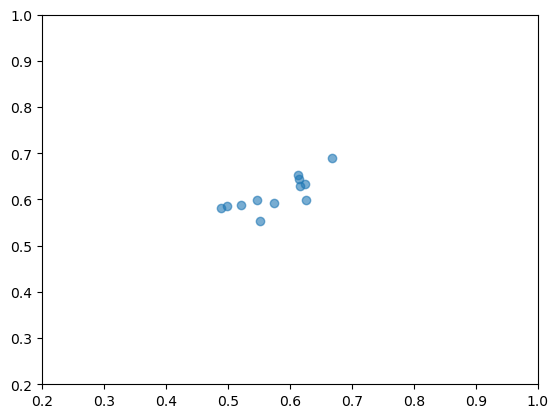

In [58]:


# Create scatter plot
plt.scatter(nse_results_cal_r_1_sumaxroot["bfi_obs"], nse_results_cal_r_1_sumaxroot["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [236]:
perm_areas

{'DERP2017': [0.74, 0.26, 0.0],
 'DERP2033': [0.25, 0.67, 0.08],
 'DERP2007': [0.07, 0.93, 0.0],
 'DERP2024': [0.3, 0.65, 0.05],
 'FR003253': [0.55, 0.22, 0.23],
 'FR003308': [0.0, 1.0, 0.0],
 'FR003283': [0.1, 0.9, 0.0],
 'FR003301': [0.15, 0.85, 0.0],
 'DERP2003': [0.5, 0.5, 0.0],
 'FR003265': [0.26, 0.61, 0.13],
 'FR003272': [0.21, 0.7, 0.09],
 'DEBU1958': [0.28, 0.68, 0.04]}

In [341]:
perm_areas

{'DERP2028': [0.8, 0.07, 0.13],
 'DERP2006': [0.04, 0.11, 0.85],
 'FR003306': [0.94, 0.06, 0.0],
 'BEWA0106': [0.0, 0.0, 1.0],
 'DERP2027': [0.17, 0.48, 0.35],
 'FR003234': [0.03, 0.0, 0.97],
 'FR003259': [0.66, 0.34, 0.0],
 'FR003250': [0.04, 0.0, 0.96],
 'FR000183': [0.66, 0.29, 0.05],
 'FR000124': [0.03, 0.0, 0.97],
 'FR003280': [0.0, 1.0, 0.0],
 'DERP2016': [0.27, 0.6, 0.13],
 'BEWA0107': [0.04, 0.15, 0.81],
 'LU000018': [0.39, 0.61, 0.0],
 'FR000184': [0.98, 0.02, 0.0],
 'FR003303': [0.98, 0.02, 0.0],
 'FR000132': [0.45, 0.0, 0.55],
 'DERP2008': [0.03, 0.03, 0.94],
 'BEWA0067': [0.02, 0.0, 0.98],
 'DERP2017': [0.25, 0.26, 0.49],
 'FR003239': [0.32, 0.68, 0.0],
 'FR003288': [0.29, 0.71, 0.0],
 'DERP2015': [0.55, 0.45, 0.0],
 'FR003254': [0.64, 0.36, 0.0],
 'FR000137': [0.09, 0.91, 0.0],
 'FR000144': [0.92, 0.0, 0.08],
 'DERP2031': [0.14, 0.18, 0.68],
 'DERP2005': [0.0, 0.12, 0.88],
 'FR000174': [0.0, 1.0, 0.0],
 'FR003274': [0.0, 1.0, 0.0],
 'DERP2010': [0.25, 0.47, 0.28],
 'FR0032

In [106]:
catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']


# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}
waterdeficit_mean = {}

for basin_id in tqdm.tqdm(catchments_ids):
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    data = data.loc["1988":"2001", :]
    #data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()

    data['S_dem(t-1)'] = np.nan
    data['S_dem(t)'] = np.nan

    # Initialize the first row manually
    data.iloc[0, data.columns.get_loc('S_dem(t-1)')] = 0
    data.iloc[0, data.columns.get_loc('S_dem(t)')] = max(0, data.iloc[0]['S_dem(t-1)'] + (data.iloc[0]['pet_mean'] - data.iloc[0]['p_mean']) * 1.0)

    # Compute S_dem(t-1) and S_dem(t) for the rest of the rows
    for i in range(1, len(data)):
        data.iloc[i, data.columns.get_loc('S_dem(t-1)')] = data.iloc[i-1, data.columns.get_loc('S_dem(t)')]
        data.iloc[i, data.columns.get_loc('S_dem(t)')] = max(0, data.iloc[i]['S_dem(t-1)'] + (data.iloc[i]['pet_mean'] - data.iloc[i]['p_mean']) * 1.0)
        
    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)


    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]
    waterdeficit_mean[basin_id] = 1.1*data["S_dem(t)"].max()
    

# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:


    unsaturated = CustomUnsaturatedReservoir(
        parameters={'Csmax': 1.5, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0, 'bacon': waterdeficit_mean[cat_id]},
        states={'S0': 10.0},
        approximation=num_app,
        id='unsaturated')


    general = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='general'
    )

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low'
    )

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high'
    )

    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    
    node.set_input(inputs[cat_id])  # Correct way to set inputs
    
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    #globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs

for key in model._content_pointer.keys():
    i = model._content_pointer[key] 
    model._content[i].set_parameters(best_params_dict_model)

model.set_timestep(1.0)

100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


In [107]:
#hyd_mod.reset_states()
output = model.get_output()
output

{'DERP2011': [array([3.27309673e-08, 2.49561463e-06, 5.21987251e-06, ...,
         1.60693238e+00, 1.16825850e+00, 9.28788810e-01])],
 'FR003275': [array([1.11387737e-08, 3.15298218e-07, 1.19427573e-06, ...,
         2.36800561e+00, 2.18770031e+00, 1.50864163e+00])],
 'DERP2004': [array([2.27414645e-08, 1.14871270e-06, 2.59961058e-06, ...,
         1.45467753e+00, 1.16658617e+00, 9.60343239e-01])],
 'FR003271': [array([0.00000000e+00, 2.40000163e-09, 5.31831072e-09, ...,
         1.84552034e+00, 1.77531253e+00, 1.17949339e+00])],
 'LU000007': [array([4.56286818e-09, 2.71720446e-07, 6.71581954e-07, ...,
         2.27492813e+00, 1.74341045e+00, 1.68019557e+00])],
 'FR003237': [array([2.84166996e-12, 6.34317033e-07, 3.50777260e-06, ...,
         1.52019432e+00, 1.16444956e+00, 9.22725772e-01])],
 'FR000159': [array([1.79799994e-09, 1.83216172e-07, 3.60742161e-07, ...,
         2.00315465e+00, 1.55572067e+00, 1.08953600e+00])],
 'DEBU1957': [array([2.34780722e-09, 8.42010705e-08, 1.9727743

In [109]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_wd = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_wd

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_5768\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_5768\654760136.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,AlsdorfOberecken,DERP2011,0.486574,0.911970,1.334360,0.567073,0.468451,0.597806
1,L'Orne Ã Boncourt,FR003275,0.420018,0.682736,1.162408,0.429987,0.503505,0.054934
2,GemuendOur,DERP2004,0.612252,1.259518,1.667933,0.500469,0.466402,0.706293
3,La Seille Ã Nomeny,FR003271,0.394855,0.698123,0.723752,0.557788,0.528648,0.251834
4,EttelbrueckAlzette,LU000007,NaN,NaN,1.106602,NaN,NaN,NaN
5,La Moselle Ã Ã‰pinal,FR003237,0.394975,2.574201,2.824502,0.560015,0.379446,0.430617
6,A7881010,FR000171,0.381522,0.637797,0.696770,0.517493,0.530546,0.249177
7,A6941020,FR000159,0.428063,1.265186,1.341116,0.592704,0.433067,NaN
8,La Moselle Ã Toul,FR003249,0.477092,1.571429,2.012810,0.567660,0.435709,0.737528
9,BundespegelFremersdorf,DEBU1957,0.541854,0.876168,1.079404,0.608043,0.474807,0.513097


In [110]:
nse_results_val_r_1_wd.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_5768\2822077768.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_wd.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,-0.057429,0.063996,0.202560,-0.083999,0.734743
q_mean_obs,-0.057429,1.000000,0.963629,0.211681,-0.923187,0.303989
q_mean_calc,0.063996,0.963629,1.000000,0.080931,-0.920544,0.343951
bfi_obs,0.202560,0.211681,0.080931,1.000000,-0.321434,0.641821
bfi_sim,-0.083999,-0.923187,-0.920544,-0.321434,1.000000,-0.437952
nse_value_bfi,0.734743,0.303989,0.343951,0.641821,-0.437952,1.000000


(0.2, 1.0)

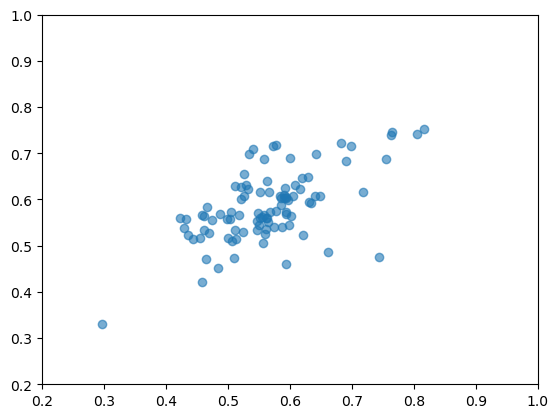

In [78]:


# Create scatter plot
plt.scatter(nse_results_val_r_1_sumaxroot["bfi_obs"], nse_results_val_r_1_sumaxroot["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [85]:
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()

best_params_dict_model = {'high_snow_k': 4.086426297944429,
 'high_unsaturated_Ce': 0.9567288089362507,
 'high_unsaturated_beta': 1.0331337523819135,
 'high_slowhigh_k': 0.0013319218103794586,
 'general_snow_k': 4.086426297944429,
 'general_unsaturated_Ce': 0.9567288089362507,
 'general_unsaturated_beta': 1.0331337523819135,
 'general_slow_k': 0.011234798028853129,
 'general_lag-fun_lag-time': 3.9750011064022424,
 'general_fast_k': 0.48590540089635903,
 'low_snow_k': 4.086426297944429,
 'low_unsaturated_Ce': 0.9567288089362507,
 'low_unsaturated_beta': 1.0331337523819135,
 'low_fast_k': 0.004905033249936297}


# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']


# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}
rootdepth_mean = {}

for basin_id in catchments_ids:
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    data = data.loc["1988":"2001", :]
    #data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    quality_masks[basin_id] = quality
    rootdepth_mean[basin_id] = estreams_attributes.loc[basin_id, "root_dep_mean"]

# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:


    unsaturated = UnsaturatedReservoir(
        parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
        states={'S0': 10.0},
        approximation=num_app,
        id='unsaturated'
    )



    general = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [lower_splitter],
            [slow, lag_fun],
            [lower_transparent, fast],
            [lower_junction],
        ],
        id='general'
    )

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low'
    )

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high'
    )

    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    
    node.set_input(inputs[cat_id])  # Correct way to set inputs
    
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    #globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs

for key in model._content_pointer.keys():
    i = model._content_pointer[key] 
    model._content[i].set_parameters(best_params_dict_model)

model.set_timestep(1.0)



#hyd_mod.reset_states()
output = model.get_output()
output

{'DERP2028': [array([1.32666901e-03, 3.57196173e-02, 7.99417680e-02, ...,
         1.81341483e+00, 1.63323954e+00, 1.46347958e+00])],
 'DERP2006': [array([0.0048046 , 0.12235405, 0.24208055, ..., 1.57962002, 1.45818485,
         1.18804993])],
 'FR003306': [array([7.88721175e-05, 1.55326723e-03, 4.01032907e-03, ...,
         2.22736808e+00, 1.99315023e+00, 1.80938793e+00])],
 'BEWA0106': [array([0.00148733, 0.04220818, 0.09615582, ..., 1.29586441, 1.12298726,
         0.98195911])],
 'DERP2027': [array([0.00268563, 0.05872494, 0.16500353, ..., 1.58459345, 1.77926536,
         1.24795236])],
 'FR003234': [array([8.99089243e-04, 1.08598749e-01, 2.28203172e-01, ...,
         1.71157692e+00, 1.45963007e+00, 1.25871658e+00])],
 'FR003259': [array([6.21391238e-04, 1.25015797e-02, 3.93702183e-02, ...,
         1.48795740e+00, 1.30015450e+00, 1.19440256e+00])],
 'FR003250': [array([9.80838340e-05, 2.37071530e-02, 5.89371498e-02, ...,
         1.15495591e+00, 1.01161895e+00, 8.93130125e-01])],


In [86]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_8228\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_8228\4023551318.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\min

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Eisenschmitt,DERP2028,0.840568,1.147362,1.177583,0.577985,0.603856,0.819376
1,Pruem,DERP2006,0.837414,1.491720,1.494320,0.435240,0.531085,0.833029
2,La Bisten Ã Creutzwald,FR003306,-2.075374,1.130278,0.790138,0.764163,0.615715,NaN
3,Reuland,BEWA0106,0.759683,1.243036,1.239887,0.506445,0.523732,NaN
4,Muellenborn,DERP2027,0.775176,1.252571,1.129610,0.585400,0.604246,0.691616
...,...,...,...,...,...,...,...,...
107,La Moselle Ã Hagondange et Ã Hauconcourt,FR003272,0.851075,1.137169,1.293391,0.584542,0.590742,0.863295
108,La Moselle Ã Uckange,FR003284,0.856313,1.050769,1.243439,0.590117,0.596825,0.851772
109,BundespegelPerl,DEBU1956,0.879837,1.079179,1.212330,0.586521,0.600124,0.896342
110,BundespegelTrierUp,DEBU1958,0.881359,0.979012,1.133456,0.593301,0.607148,0.864039


In [96]:
first_half_df.index.tolist()

['DERP2017',
 'DERP2033',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [97]:
basins_to_exclude = ['DERP2017',
 'DERP2033',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']



data_diff = pd.DataFrame(data=nse_results_val_r_1_sumaxroot.nse - nse_results_val_r_1.nse)
data_diff.index = nse_results_val_r_1_sumaxroot.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(basins_to_exclude)]
data_diff_filtered["nse_r1"] = nse_results_val_r_1.set_index("basin", inplace = False).nse
data_diff_filtered["nse_r1sumaxroot"] = nse_results_val_r_1_sumaxroot.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_val_r_1.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_r1sumaxroot"] = nse_results_val_r_1_sumaxroot.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_8228\3506336047.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1"] = nse_results_val_r_1.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_8228\3506336047.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1sumaxroot"] = nse_results_val_r_1_sumaxroot.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_8228\3506336047.py:21: SettingWi

,nse,nse_r1,nse_r1sumaxroot,nse_bfi_r1,nse_bfi_r1sumaxroot
basin,,,,,
DERP2028,-0.110794,0.840568,0.729773,0.819376,0.503684
DERP2006,-0.001701,0.837414,0.835713,0.833029,0.800992
FR003306,0.815260,-2.075374,-1.260114,NaN,NaN
BEWA0106,-0.096143,0.759683,0.663540,NaN,NaN
DERP2027,-0.032436,0.775176,0.742740,0.691616,0.439855
...,...,...,...,...,...
LU000017,NaN,NaN,NaN,NaN,NaN
DEBU1957,-0.064753,0.852105,0.787352,0.769417,0.507690
FR003284,-0.047529,0.856313,0.808784,0.851772,0.747494


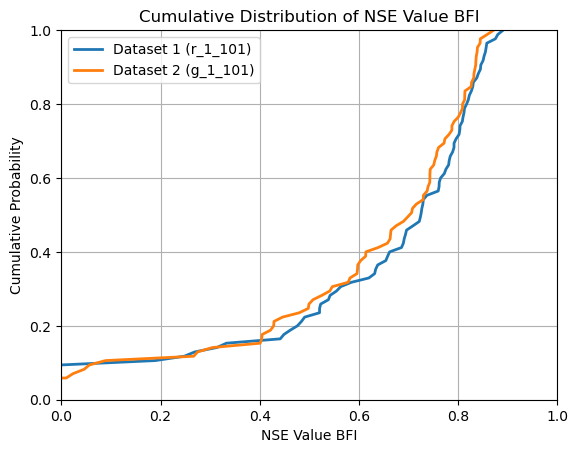

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_r1sumaxroot"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


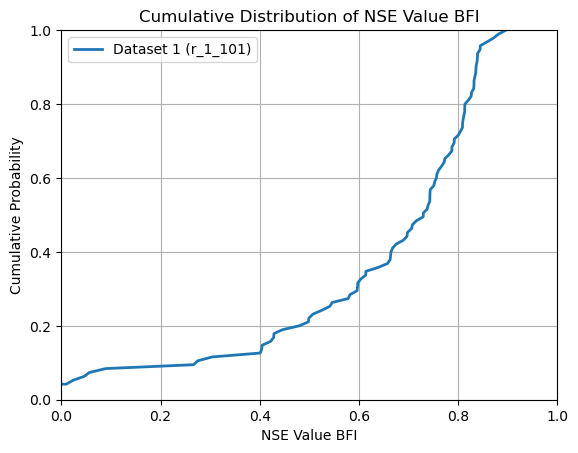

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse"].dropna())
#nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
#cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
#plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [ ]:
# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

# Initialize the dictionary
inputs = {}
observations = {}
areas = {}
perm_areas = {}
quality_masks = {}

for basin_id in catchments_ids:
    
    data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

    area = network_estreams.loc[basin_id, "area_estreams"]

    data["Q"] = data.loc[:, "q_mean"]
    data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)

    # Define the subset to be used:
    data = data.loc["1988":"2001", :]
    #data = data.loc["2002":"2015"]

    # Interpolate when needed:
    data['pet_mean'] = data['pet_mean'].interpolate()
    data['t_mean'] = data['t_mean'].interpolate()
    data['p_mean'] = data['p_mean'].interpolate()

    # Save the variables:
    Q_obs = data.loc[:, "Q"].values
    P = data.loc[:, "p_mean"].values
    E = data.loc[:, "pet_mean"].values
    T = data.loc[:, "t_mean"].values
    quality =  (pd.isna(Q_obs)).astype(int)

    inputs[basin_id] = [P, T, E]
    observations[basin_id] = Q_obs
    areas[basin_id] = area
    perm_areas[basin_id] = [round(estreams_attributes.loc[basin_id, "perm_high_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100, 2), 
                            round(estreams_attributes.loc[basin_id, "perm_low_regi"] / 100, 2)]
    quality_masks[basin_id] = quality
    

for cat_id in catchments_ids:
    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict_model)

#hyd_mod.reset_states()
output = model.get_output()
output

{'DERP2028': [array([1.32666901e-03, 3.57196173e-02, 7.99417680e-02, ...,
         1.81341483e+00, 1.63323954e+00, 1.46347958e+00])],
 'DERP2006': [array([0.0048046 , 0.12235405, 0.24208055, ..., 1.57962002, 1.45818485,
         1.18804993])],
 'FR003306': [array([7.88721175e-05, 1.55326723e-03, 4.01032907e-03, ...,
         2.22736808e+00, 1.99315023e+00, 1.80938793e+00])],
 'BEWA0106': [array([0.00148733, 0.04220818, 0.09615582, ..., 1.29586441, 1.12298726,
         0.98195911])],
 'DERP2027': [array([0.00268563, 0.05872494, 0.16500353, ..., 1.58459345, 1.77926536,
         1.24795236])],
 'FR003234': [array([8.99089243e-04, 1.08598749e-01, 2.28203172e-01, ...,
         1.71157692e+00, 1.45963007e+00, 1.25871658e+00])],
 'FR003259': [array([6.21391238e-04, 1.25015797e-02, 3.93702183e-02, ...,
         1.48795740e+00, 1.30015450e+00, 1.19440256e+00])],
 'FR003250': [array([9.80838340e-05, 2.37071530e-02, 5.89371498e-02, ...,
         1.15495591e+00, 1.01161895e+00, 8.93130125e-01])],


In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\4023551318.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,AlsdorfOberecken,DERP2011,0.785324,0.911970,1.135518,0.567073,0.617591,0.635125
1,L'Orne Ã Boncourt,FR003275,0.457426,0.682736,1.055180,0.429987,0.616605,-0.384332
2,GemuendOur,DERP2004,0.827638,1.259518,1.391146,0.500469,0.528668,0.848751
3,La Seille Ã Nomeny,FR003271,0.733814,0.698123,0.746930,0.557788,0.626772,0.573837
4,EttelbrueckAlzette,LU000007,NaN,NaN,0.994023,NaN,NaN,NaN
5,La Moselle Ã Ã‰pinal,FR003237,0.803078,2.574201,2.368009,0.560015,0.491756,0.750260
6,A7881010,FR000171,0.715938,0.637797,0.737554,0.517493,0.626860,0.464088
7,A6941020,FR000159,0.860682,1.265186,1.124749,0.592704,0.589647,NaN
8,La Moselle Ã Toul,FR003249,0.878703,1.571429,1.672704,0.567660,0.558848,0.925652
9,BundespegelFremersdorf,DEBU1957,0.863368,0.876168,0.957166,0.608043,0.628015,0.786237


In [400]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)

    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        bfi_sim_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    
    except:
        nse_value_bfi = np.nan
        bfi_obs_series = np.nan
        bfi_sim_series = np.nan
    
    try:

        # Ensure inputs are NumPy arrays
        bfi_obs_series = np.array(bfi_obs_series, dtype=np.float64)
        bfi_sim_series = np.array(bfi_sim_series, dtype=np.float64)





        r2_value_bfi = 1 - np.sum((bfi_obs_series - bfi_sim_series) ** 2) / np.sum((bfi_obs_series - np.mean(bfi_obs_series)) ** 2)
    except:
        r2_value_bfi = np.nan


    try:
        bfi_obs2 = np.mean(bfi_obs_series)/mean_q_obs
        bfi_sim2 = np.mean(bfi_sim_series)/mean_q_calc
    except:    
        bfi_obs2 = np.nan
        bfi_sim2 = np.nan    

    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi,
        "bfi_obs2": bfi_obs2,
        "bfi_sim2":bfi_sim2,
        "r2_value_bfi":r2_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_56 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_56

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3800118984.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi,bfi_obs2,bfi_sim2,r2_value_bfi
0,Eisenschmitt,DERP2028,0.840568,1.147362,1.177583,0.577985,0.603856,0.819376,0.577985,0.603856,0.864155
1,Pruem,DERP2006,0.837414,1.491720,1.494320,0.435240,0.531085,0.833029,0.435240,0.531085,0.873014
2,La Bisten Ã Creutzwald,FR003306,-2.075374,1.130278,0.790138,0.764163,0.615715,NaN,NaN,NaN,NaN
3,Reuland,BEWA0106,0.759683,1.243036,1.239887,0.506445,0.523732,NaN,NaN,NaN,NaN
4,Muellenborn,DERP2027,0.775176,1.252571,1.129610,0.585400,0.604246,0.691616,0.585400,0.604246,0.820636
...,...,...,...,...,...,...,...,...,...,...,...
107,La Moselle Ã Hagondange et Ã Hauconcourt,FR003272,0.851075,1.137169,1.293391,0.584542,0.590742,0.863295,0.584542,0.590742,0.874886
108,La Moselle Ã Uckange,FR003284,0.856313,1.050769,1.243439,0.590117,0.596825,0.851772,0.590117,0.596825,0.845720
109,BundespegelPerl,DEBU1956,0.879837,1.079179,1.212330,0.586521,0.600124,0.896342,0.586521,0.600124,0.905053
110,BundespegelTrierUp,DEBU1958,0.881359,0.979012,1.133456,0.593301,0.607148,0.864039,0.593301,0.607148,0.847516


In [388]:
nse_results_val_r_1_56.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3844970285.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_56.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi,bfi_obs2,bfi_sim2
nse,1.000000,0.176772,0.011312,-0.325126,0.124735,0.977759,-0.538506,-0.184636
q_mean_obs,0.176772,1.000000,0.916090,-0.030378,-0.699982,0.160864,-0.093380,-0.867944
q_mean_calc,0.011312,0.916090,1.000000,-0.041997,-0.757381,0.162293,-0.077862,-0.882749
bfi_obs,-0.325126,-0.030378,-0.041997,1.000000,0.216645,-0.468267,1.000000,0.222011
bfi_sim,0.124735,-0.699982,-0.757381,0.216645,1.000000,-0.244030,0.222011,1.000000
nse_value_bfi,0.977759,0.160864,0.162293,-0.468267,-0.244030,1.000000,-0.468267,-0.244030
bfi_obs2,-0.538506,-0.093380,-0.077862,1.000000,0.222011,-0.468267,1.000000,0.222011
bfi_sim2,-0.184636,-0.867944,-0.882749,0.222011,1.000000,-0.244030,0.222011,1.000000


(0.2, 1.0)

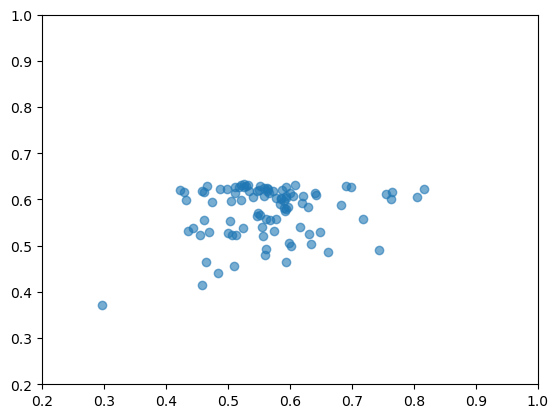

In [101]:

# Create scatter plot
plt.scatter(nse_results_val_r_1["bfi_obs"], nse_results_val_r_1["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [369]:
hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values)[1]

TypeError: calculate_baseflow_index() missing 1 required positional argument: 'quality'

In [327]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1_56 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1_56

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3246502077.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Eisenschmitt,DERP2028,0.821702,1.147362,1.259830,0.577985,0.638305,0.759286
1,Pruem,DERP2006,0.741682,1.491720,1.582982,0.435240,0.611256,0.490220
2,La Bisten Ã Creutzwald,FR003306,-1.553516,1.130278,0.865027,0.764163,0.642448,NaN
3,Reuland,BEWA0106,0.718581,1.243036,1.327826,0.506445,0.643626,NaN
4,Muellenborn,DERP2027,0.754011,1.252571,1.211408,0.585400,0.617581,0.603563
...,...,...,...,...,...,...,...,...
107,La Moselle Ã Hagondange et Ã Hauconcourt,FR003272,0.731452,1.137169,1.385993,0.584542,0.576589,0.805779
108,La Moselle Ã Uckange,FR003284,0.734704,1.050769,1.334472,0.590117,0.582108,0.786845
109,BundespegelPerl,DEBU1956,0.774438,1.079179,1.302438,0.586521,0.584988,0.848926
110,BundespegelTrierUp,DEBU1958,0.802650,0.979012,1.220215,0.593301,0.607057,0.765674


In [177]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\750531115.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')


,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,AlsdorfOberecken,DERP2011,0.719454,0.911970,1.219642,0.567073,0.622329,0.412628
1,L'Orne Ã Boncourt,FR003275,0.459961,0.682736,1.138163,0.429987,0.595592,-0.279350
2,GemuendOur,DERP2004,0.783289,1.259518,1.481209,0.500469,0.640798,0.559119
3,La Seille Ã Nomeny,FR003271,0.691560,0.698123,0.822981,0.557788,0.599933,0.552354
4,EttelbrueckAlzette,LU000007,NaN,NaN,1.072274,NaN,NaN,NaN
5,La Moselle Ã Ã‰pinal,FR003237,0.606200,2.574201,2.484484,0.560015,0.457091,0.747610
6,A7881010,FR000171,0.674424,0.637797,0.813315,0.517493,0.601111,0.444057
7,A6941020,FR000159,0.824137,1.265186,1.212922,0.592704,0.585360,NaN
8,La Moselle Ã Toul,FR003249,0.740401,1.571429,1.775374,0.567660,0.534191,0.904582
9,BundespegelFremersdorf,DEBU1957,0.815946,0.876168,1.038583,0.608043,0.621781,0.618216


In [179]:
nse_results_val_r_1.nse_value_bfi - nse_results_val_g_1.nse_value_bfi

0     0.222497
1    -0.104982
2     0.289633
3     0.021482
4          NaN
5     0.002650
6     0.020032
7          NaN
8     0.021070
9     0.168021
10    0.034502
11    0.050224
Name: nse_value_bfi, dtype: float64

In [216]:
nse_results_cal_g_1_56

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim
0,Eisenschmitt,DERP2028,0.750561,0.932864,0.861938,0.600504,0.666399
1,La Bisten Ã Creutzwald,FR003306,-1.443603,0.530436,0.641511,0.749280,0.656876
2,Muellenborn,DERP2027,0.710816,0.989966,0.844021,0.564320,0.622935
3,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR003259,0.242517,0.817462,1.237648,0.587749,0.625627
4,A9001050,FR000183,0.748868,1.083956,1.116261,0.699445,0.634157
5,Le Woigot Ã Briey,FR003280,0.568781,1.276007,0.871010,0.687017,0.598718
6,Lommersweiler,BEWA0107,0.709137,1.134366,1.326023,0.565604,0.653921
7,A9013050,FR000184,0.474399,1.268439,1.151511,0.769605,0.661996
8,A4333010,FR000132,0.496038,1.713987,2.167143,0.661763,0.590110
9,Schoenberg,BEWA0067,0.713074,1.397246,1.340834,0.443161,0.646707


<Axes: >

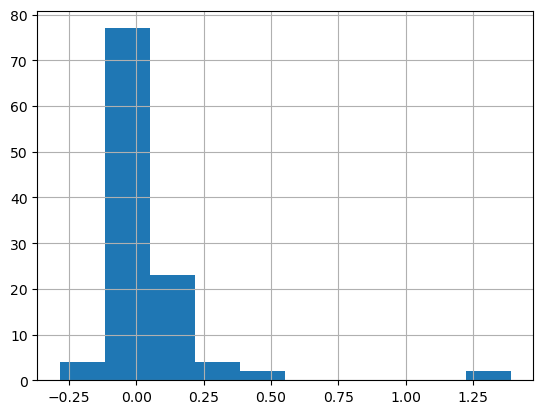

In [256]:
(nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse).hist()

In [257]:
nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse

0     -0.028545
1      0.070389
2     -0.283018
3      0.095308
4     -0.019182
         ...   
107    0.118979
108    0.106295
109    0.102065
110    0.040548
111    0.056221
Name: nse, Length: 112, dtype: float64

In [ ]:
nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56

<Axes: >

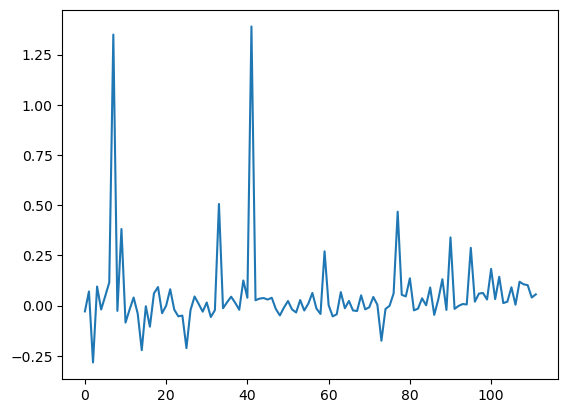

In [402]:
(nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse).plot()

<Axes: >

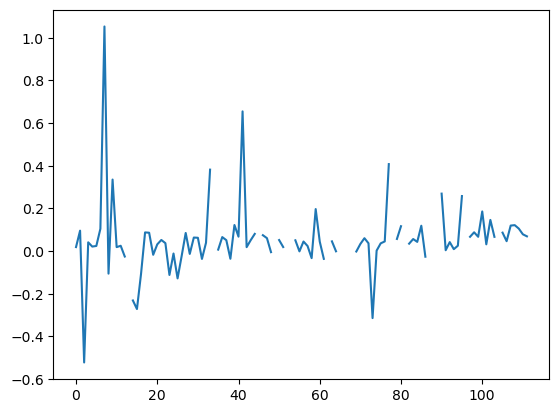

In [403]:
(nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse).plot()

In [283]:
nse_results_cal_r_1_56

,gauge_name,basin,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
0,Eisenschmitt,DERP2028,0.722016,0.932864,0.780917,0.600504,0.635447,0.614705
1,Pruem,DERP2006,0.784086,1.366707,1.089608,0.440082,0.543718,0.848413
2,La Bisten Ã Creutzwald,FR003306,-1.726621,0.530436,0.567962,0.749280,0.632251,NaN
3,Reuland,BEWA0106,0.780962,0.986279,0.858566,0.473400,0.540053,NaN
4,Muellenborn,DERP2027,0.691634,0.989966,0.763480,0.564320,0.617434,0.677778
...,...,...,...,...,...,...,...,...
107,La Moselle Ã Hagondange et Ã Hauconcourt,FR003272,0.865887,1.101628,1.050630,0.615765,0.611945,NaN
108,La Moselle Ã Uckange,FR003284,0.883391,0.976771,0.997556,0.611175,0.621547,NaN
109,BundespegelPerl,DEBU1956,0.876971,0.952513,0.967253,0.610835,0.626602,0.895002
110,BundespegelTrierUp,DEBU1958,0.907044,0.926721,0.881482,0.623734,0.633677,0.923896


In [304]:
data_diff = pd.DataFrame(data=nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse)
data_diff.index = nse_results_cal_r_1_56.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(nse_results_cal_g_1.basin.tolist())]
data_diff_filtered["nse_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3975857742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3975857742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3975857742.py:6: SettingWithCopyWarning

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1
basin,,,,,
DERP2028,-0.028545,0.722016,0.750561,0.614705,0.728783
DERP2006,0.070389,0.784086,0.713696,0.848413,0.597656
FR003306,-0.283018,-1.726621,-1.443603,NaN,NaN
BEWA0106,0.095308,0.780962,0.685655,NaN,NaN
DERP2027,-0.019182,0.691634,0.710816,0.677778,0.694958
...,...,...,...,...,...
LU000017,0.019806,0.860317,0.840511,0.860166,0.770080
DEBU1957,0.004494,0.860918,0.856424,0.872531,0.769682
FR003284,0.106295,0.883391,0.777096,NaN,NaN


In [293]:
data_diff.loc[data_diff.index.isin(nse_results_cal_g_1.basin.tolist())]

,nse
basin,
DERP2017,-0.037738
DERP2033,0.002423
DERP2007,-0.000843
DERP2024,-0.015032
FR003253,0.131578
FR003283,-0.016056
FR003301,0.008095
DERP2003,0.032592
FR003265,0.091474


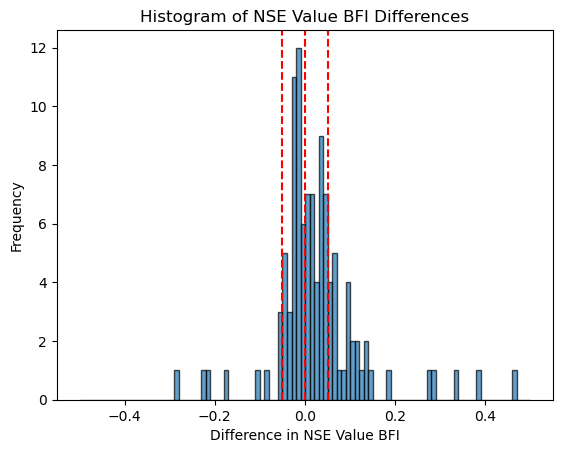

In [296]:
# Compute the difference
data_diff = nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [323]:
data_diff_filtered[data_diff_filtered.nse_g1>0.85]

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1
basin,,,,,
DERP2031,-0.022155,0.851416,0.873572,0.859001,0.870702
FR000190,0.012726,0.868503,0.855777,NaN,NaN
DEBU1957,0.004494,0.860918,0.856424,0.872531,0.769682


In [322]:
data_diff_filtered[data_diff_filtered.nse_r1>0.85]

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1
basin,,,,,
DERP2031,-0.022155,0.851416,0.873572,0.859001,0.870702
DERP2030,0.016728,0.855581,0.838853,0.897792,0.811043
DERP2018,0.026893,0.874434,0.847540,0.899372,0.786580
BEWA0066,0.063073,0.852221,0.789147,0.883178,0.673196
FR000140,0.182986,0.864152,0.681166,NaN,NaN
FR003249,0.143675,0.873384,0.729710,NaN,NaN
FR000190,0.012726,0.868503,0.855777,NaN,NaN
LU000017,0.019806,0.860317,0.840511,0.860166,0.770080
DEBU1957,0.004494,0.860918,0.856424,0.872531,0.769682


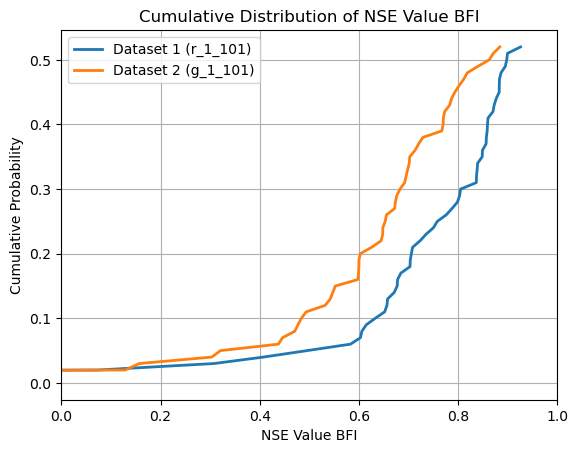

In [311]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"])
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

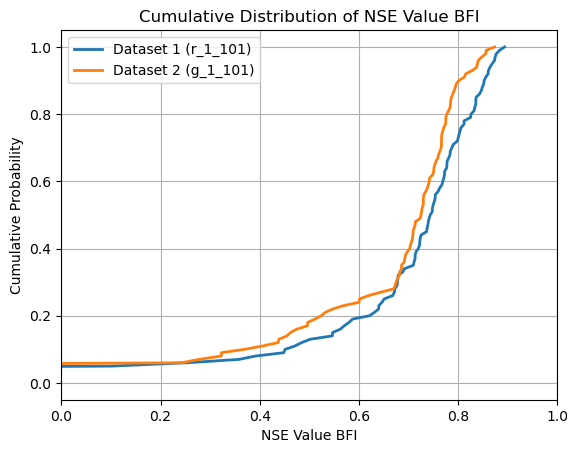

In [312]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse_r1"])
nse_values_2 = np.sort(data_diff_filtered["nse_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

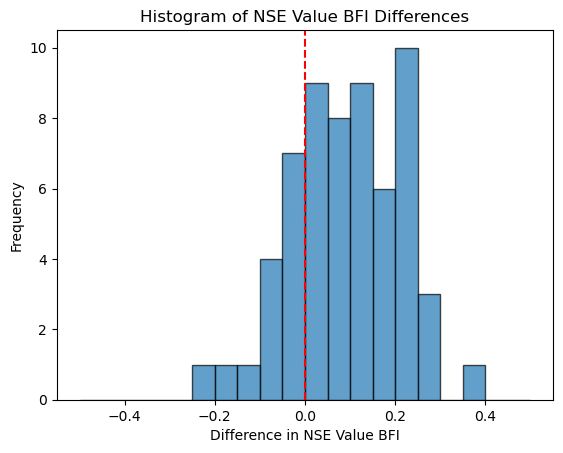

In [274]:



# Compute the difference
data_diff = nse_results_cal_r_1_56.nse_value_bfi - nse_results_cal_g_1_56.nse_value_bfi

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.05  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [364]:
nse_results_val_r_1_56.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3844970285.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_56.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.176772,0.011312,-0.325126,0.124735,0.977759
q_mean_obs,0.176772,1.000000,0.916090,-0.030378,-0.699982,0.160864
q_mean_calc,0.011312,0.916090,1.000000,-0.041997,-0.757381,0.162293
bfi_obs,-0.325126,-0.030378,-0.041997,1.000000,0.216645,-0.468267
bfi_sim,0.124735,-0.699982,-0.757381,0.216645,1.000000,-0.244030
nse_value_bfi,0.977759,0.160864,0.162293,-0.468267,-0.244030,1.000000


In [365]:
nse_results_val_g_1_56.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2280507530.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_g_1_56.corr()


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim,nse_value_bfi
nse,1.000000,0.149459,-0.017611,-0.307942,-0.016141,0.934301
q_mean_obs,0.149459,1.000000,0.915896,-0.030378,-0.728235,0.174928
q_mean_calc,-0.017611,0.915896,1.000000,-0.040614,-0.685371,0.175700
bfi_obs,-0.307942,-0.030378,-0.040614,1.000000,0.193857,-0.374946
bfi_sim,-0.016141,-0.728235,-0.685371,0.193857,1.000000,-0.180368
nse_value_bfi,0.934301,0.174928,0.175700,-0.374946,-0.180368,1.000000


In [344]:
data_diff = pd.DataFrame(data=nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse)
data_diff.index = nse_results_val_r_1_56.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(nse_results_val_g_1.basin.tolist())]
data_diff_filtered["nse_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\37989104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\37989104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\37989104.py:6: SettingWithCopyWarning: 
A v

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1
basin,,,,,
DERP2028,0.018866,0.840568,0.821702,0.819376,0.759286
DERP2006,0.095733,0.837414,0.741682,0.833029,0.490220
FR003306,-0.521858,-2.075374,-1.553516,NaN,NaN
BEWA0106,0.041102,0.759683,0.718581,NaN,NaN
DERP2027,0.021165,0.775176,0.754011,0.691616,0.603563
...,...,...,...,...,...
LU000017,NaN,NaN,NaN,NaN,NaN
FR003265,0.086493,0.897362,0.810869,0.933779,0.912916
FR003272,0.119622,0.851075,0.731452,0.863295,0.805779


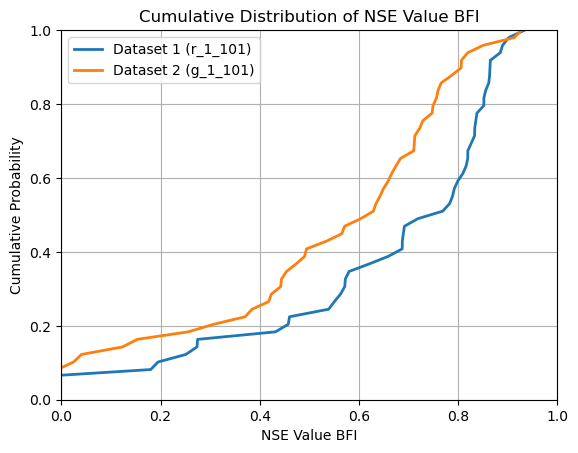

In [359]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


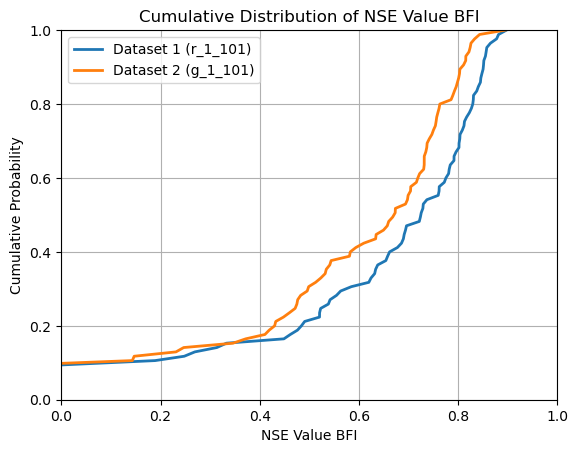

In [360]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [352]:
cumulative_2

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [355]:
nse_values_1

array([-2.41420749e+01, -2.36495207e+00, -2.07537404e+00, -1.65455405e+00,
       -3.24438751e-01, -1.96978745e-01, -1.93807742e-01, -2.89739331e-04,
        1.88914310e-01,  2.47714664e-01,  2.69030322e-01,  3.13399533e-01,
        3.32734949e-01,  4.48532638e-01,  4.61506959e-01,  4.75890867e-01,
        4.83935693e-01,  4.90463312e-01,  5.20366063e-01,  5.20515842e-01,
        5.22671925e-01,  5.38277587e-01,  5.41683494e-01,  5.54629307e-01,
        5.63051645e-01,  5.84582309e-01,  6.19818945e-01,  6.24230357e-01,
        6.31592128e-01,  6.33550396e-01,  6.37698953e-01,  6.54113739e-01,
        6.57682146e-01,  6.61703945e-01,  6.77429613e-01,  6.85670552e-01,
        6.89457181e-01,  6.91084566e-01,  6.93723283e-01,  6.95760730e-01,
        7.21530044e-01,  7.23724523e-01,  7.25470138e-01,  7.28759079e-01,
        7.29609486e-01,  7.36856909e-01,  7.59683175e-01,  7.61422201e-01,
        7.61781989e-01,  7.71956477e-01,  7.75176244e-01,  7.80650682e-01,
        7.81847262e-01,  

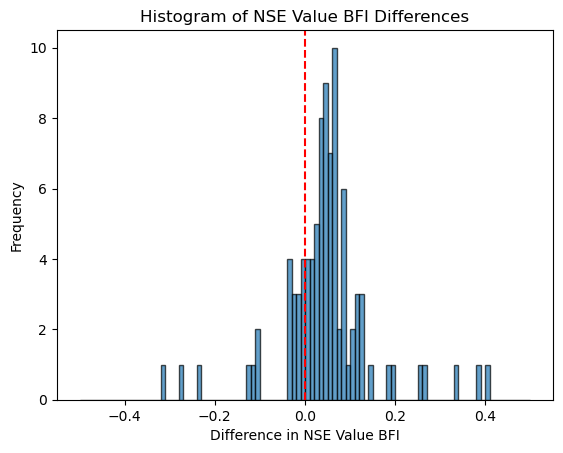

In [348]:
# Compute the difference
data_diff = nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


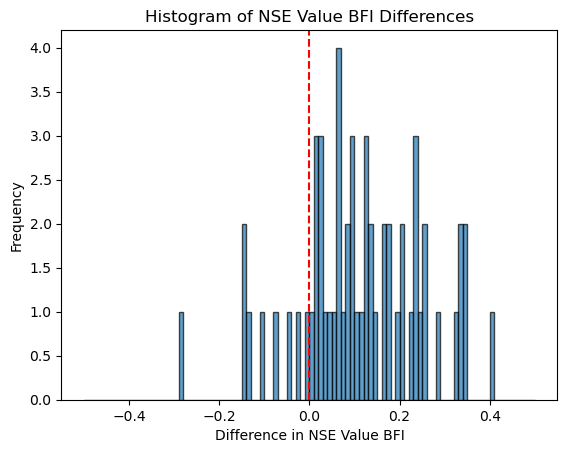

In [423]:
# Compute the difference
data_diff = nse_results_val_r_1_56.nse_value_bfi - nse_results_val_g_1_56.nse_value_bfi

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()

In [65]:
nse_results_val_r_1.corr(method="spearman")

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\1273401101.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1.corr(method="spearman")


,nse,q_mean_obs,q_mean_calc,bfi_obs,bfi_sim
nse,1.000000,0.554545,0.400000,0.800000,-0.309091
q_mean_obs,0.554545,1.000000,0.900000,0.300000,-0.881818
q_mean_calc,0.400000,0.900000,1.000000,0.045455,-0.890909
bfi_obs,0.800000,0.300000,0.045455,1.000000,0.109091
bfi_sim,-0.309091,-0.881818,-0.890909,0.109091,1.000000


In [ ]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    
    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_g_1 = pd.DataFrame(nse_results)
nse_df_g_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\669091914.py:12: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)


,gauge_name,basin,nse,q_mean_obs,q_mean_calc
0,AlsdorfOberecken,DERP2011,0.719454,0.911970,1.219642
1,L'Orne Ã Boncourt,FR003275,0.459961,0.682736,1.138163
2,GemuendOur,DERP2004,0.783289,1.259518,1.481209
3,La Seille Ã Nomeny,FR003271,0.691560,0.698123,0.822981
4,EttelbrueckAlzette,LU000007,NaN,NaN,1.072274
5,La Moselle Ã Ã‰pinal,FR003237,0.606200,2.574201,2.484484
6,A7881010,FR000171,0.674424,0.637797,0.813315
7,A6941020,FR000159,0.824137,1.265186,1.212922
8,La Moselle Ã Toul,FR003249,0.740401,1.571429,1.775374
9,BundespegelFremersdorf,DEBU1957,0.815946,0.876168,1.038583


In [186]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_r_2 = pd.DataFrame(nse_results)
nse_df_r_2

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\2593294400.py:12: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)


,gauge_name,basin,nse,q_mean_obs,q_mean_calc
0,Hentern,DERP2017,0.766067,1.395562,1.287191
1,Platten,DERP2033,0.838241,0.898401,0.980934
2,Pruemzurlay,DERP2007,0.810365,1.212015,1.198566
3,Kordel,DERP2024,0.802353,1.059166,1.094042
4,La Meurthe Ã LunÃ©ville,FR003253,0.506034,1.407706,1.386283
5,La Nied Ã Bouzonville et Ã Filstroff,FR003308,NaN,NaN,0.784570
6,L'Orne Ã Rosselange,FR003283,0.690595,0.793661,0.994270
7,La Sarre Ã Wittring,FR003301,0.808332,1.006920,0.946313
8,Bollendorf,DERP2003,0.817706,1.094215,1.094057
9,La Moselle Ã Custines,FR003265,0.823596,1.422836,1.242387


In [43]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_r_1 = pd.DataFrame(nse_results)
nse_df_r_1

ValueError: Length of values (4748) does not match length of index (4749)

In [239]:
nse_df_r_1.nse - nse_df_g_1.nse

0     0.065870
1    -0.002535
2     0.044348
3     0.042253
4          NaN
5     0.196877
6     0.041514
7     0.036544
8     0.138302
9     0.047422
10    0.092878
11    0.061087
Name: nse, dtype: float64

In [187]:
nse_df_r_2.nse - nse_df_g_2.nse

0     0.103560
1     0.048580
2     0.041449
3     0.016856
4     0.197280
5          NaN
6     0.026462
7     0.059928
8     0.045538
9     0.018005
10    0.053161
11    0.056105
Name: nse, dtype: float64

In [188]:
nse_results_cal_r_2.nse - nse_results_cal_g_2.nse

0     0.056758
1     0.035859
2     0.018530
3     0.021134
4     0.045920
5    -0.087731
6     0.014161
7     0.007300
8     0.015965
9     0.028282
10    0.021578
11    0.017464
Name: nse, dtype: float64

In [ ]:
nse_df_r_1.nse - nse_df_g_1.nse

In [240]:
nse_results_cal_r_1.nse - nse_results_cal_g_1.nse

0    -0.037738
1     0.002423
2    -0.006112
3    -0.043104
4     0.047054
5    -0.018245
6    -0.021367
7    -0.025630
8     0.019078
9     0.013949
10    0.046643
11    0.008458
Name: nse, dtype: float64

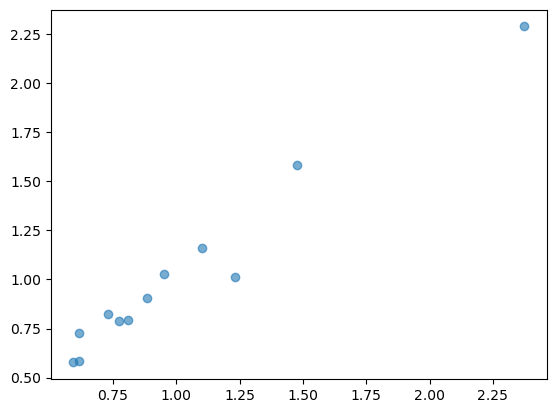

In [221]:
# Create scatter plot
plt.scatter(nse_df["q_mean_obs"], nse_df["q_mean_calc"], alpha=0.6)


In [46]:
nse_df.corr()

NameError: name 'nse_df' is not defined

In [303]:
nse_df_g

,gauge_name,basin,nse,q_mean_obs,q_mean_calc
0,AlsdorfOberecken,DERP2011,0.609061,0.911970,1.296335
1,L'Orne Ã Boncourt,FR003275,0.406974,0.682736,1.196920
2,GemuendOur,DERP2004,-0.221847,1.259518,1.581739
3,La Seille Ã Nomeny,FR003271,0.649136,0.698123,0.855776
4,EttelbrueckAlzette,LU000007,NaN,NaN,1.131707
5,La Moselle Ã Ã‰pinal,FR003237,0.023875,2.574201,2.681898
6,A7881010,FR000171,0.647980,0.637797,0.844974
7,A6941020,FR000159,0.706138,1.265186,1.290464
8,La Moselle Ã Toul,FR003249,0.474272,1.571429,1.906377
9,BundespegelFremersdorf,DEBU1957,0.746404,0.876168,1.093426


In [304]:
nse_df_h

,gauge_name,basin,nse,q_mean_obs,q_mean_calc
0,AlsdorfOberecken,DERP2011,0.713420,0.911970,1.148731
1,L'Orne Ã Boncourt,FR003275,0.218452,0.682736,1.058602
2,GemuendOur,DERP2004,0.663013,1.259518,1.417030
3,La Seille Ã Nomeny,FR003271,0.548588,0.698123,0.749305
4,EttelbrueckAlzette,LU000007,NaN,NaN,0.997414
5,La Moselle Ã Ã‰pinal,FR003237,0.557494,2.574201,2.435144
6,A7881010,FR000171,0.557819,0.637797,0.739464
7,A6941020,FR000159,0.783346,1.265186,1.144239
8,La Moselle Ã Toul,FR003249,0.771882,1.571429,1.712767
9,BundespegelFremersdorf,DEBU1957,0.761325,0.876168,0.963738


In [294]:
nse_df_h.nse - nse_df_g.nse 

0     0.104359
1    -0.188522
2     0.884861
3    -0.100549
4          NaN
5     0.533619
6    -0.090161
7     0.077208
8     0.297610
9     0.014921
10    0.130478
11    0.125518
Name: nse, dtype: float64

In [297]:
nse_results_cal_h.nse - nse_results_cal_g.nse 

AttributeError: 'list' object has no attribute 'nse'

In [302]:
nse_results_cal_h

[]

In [325]:
Qtimeseries.iloc[365:, 0].values.numpy.nanmean()

IndexError: single positional indexer is out-of-bounds

In [407]:
best_params_dict_model

{'high_snow_k': 4.086426297944429,
 'high_unsaturated_Ce': 0.9567288089362507,
 'high_unsaturated_beta': 1.0331337523819135,
 'high_slowhigh_k': 0.0013319218103794586,
 'general_snow_k': 4.086426297944429,
 'general_unsaturated_Ce': 0.9567288089362507,
 'general_unsaturated_beta': 1.0331337523819135,
 'general_slow_k': 0.011234798028853129,
 'general_lag-fun_lag-time': 3.9750011064022424,
 'general_fast_k': 0.48590540089635903,
 'low_snow_k': 4.086426297944429,
 'low_unsaturated_Ce': 0.9567288089362507,
 'low_unsaturated_beta': 1.0331337523819135,
 'low_fast_k': 0.004905033249936297}

In [426]:
data_diff_filtered[data_diff_filtered.nse<-0.05]

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1
basin,,,,,
FR003306,-0.521858,-2.075374,-1.553516,NaN,NaN
FR000183,-0.105590,-0.196979,-0.091389,NaN,NaN
FR000184,-0.231250,-0.000290,0.230961,NaN,NaN
FR003303,-0.271455,-1.654554,-1.383099,NaN,NaN
FR000132,-0.107639,0.541683,0.649323,0.579943,0.722418
FR003254,-0.111754,-0.193808,-0.082053,NaN,NaN
FR000144,-0.127971,-0.324439,-0.196467,-0.424234,-0.141920
DERP2013,-0.313903,-2.364952,-2.051049,-5.208121,-4.188421


In [437]:
estreams_attributes_clipped_filters.columns[30:]

Index(['q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perm_verylow_glob',
       'perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 'lit_fra_su',
       'lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'lit_fra_mt', 'lit_fra_pi',
       'lit_fra_py', 'lit_fra_vi', 'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa',
       'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb', 'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'lit_fra_Conglomerates', 'lit_fra_Conglomerates and sands',
       'lit_fra_Gravels', 'lit_fra_Sands', 'lit_fra_Sa

In [438]:
data_diff_filtered["perm_high_regi"] = estreams_attributes_clipped_filters["perm_high_regi"]
data_diff_filtered["root_dep_mean"] = estreams_attributes_clipped_filters["root_dep_mean"]

In [439]:
data_diff_filtered[data_diff_filtered.perm_high_regi>70]

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1,perm_high_regi,root_dep_mean
basin,,,,,,,
DERP2028,0.018866,0.840568,0.821702,0.819376,0.759286,80.0,102.000
FR003306,-0.521858,-2.075374,-1.553516,NaN,NaN,94.0,115.085
FR000184,-0.231250,-0.000290,0.230961,NaN,NaN,98.0,85.281
FR003303,-0.271455,-1.654554,-1.383099,NaN,NaN,98.0,106.250
FR000144,-0.127971,-0.324439,-0.196467,-0.424234,-0.141920,92.0,79.831
FR000185,0.122290,0.269030,0.146740,NaN,NaN,75.0,92.353
DERP2029,0.067602,0.771956,0.704354,0.620367,0.384514,73.0,116.526
FR000153,0.051809,0.483936,0.432126,NaN,NaN,76.0,111.010
DERP2013,-0.313903,-2.364952,-2.051049,-5.208121,-4.188421,91.0,116.881


In [442]:
data_diff_filtered[data_diff_filtered.root_dep_mean>110]

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1,perm_high_regi,root_dep_mean
basin,,,,,,,
FR003306,-0.521858,-2.075374,-1.553516,NaN,NaN,94.0,115.085
FR003259,0.104731,0.247715,0.142983,NaN,NaN,66.0,128.125
DERP2016,0.024988,0.783979,0.758991,0.855370,0.756186,27.0,116.842
LU000018,NaN,NaN,NaN,NaN,NaN,39.0,129.277
FR000132,-0.107639,0.541683,0.649323,0.579943,0.722418,45.0,126.042
FR003239,0.031577,0.554629,0.523052,-0.059783,-0.399673,32.0,130.000
FR003288,0.052162,0.685671,0.633509,0.538849,0.306979,29.0,110.885
DERP2015,0.037332,0.619819,0.582487,0.273496,0.152812,55.0,117.568
FR000137,-0.011256,0.661704,0.672960,NaN,NaN,9.0,130.000


In [443]:
data_diff_filtered.corr()

,nse,nse_r1,nse_g1,nse_bfi_r1,nse_bfi_g1,perm_high_regi,root_dep_mean
nse,1.000000,-0.272628,-0.331051,0.565570,0.492093,-0.386319,-0.198325
nse_r1,-0.272628,1.000000,0.998122,0.981488,0.945908,-0.014619,0.238775
nse_g1,-0.331051,0.998122,1.000000,0.966496,0.944235,0.010258,0.246809
nse_bfi_r1,0.565570,0.981488,0.966496,1.000000,0.981490,-0.487689,-0.165866
nse_bfi_g1,0.492093,0.945908,0.944235,0.981490,1.000000,-0.437892,-0.144408
perm_high_regi,-0.386319,-0.014619,0.010258,-0.487689,-0.437892,1.000000,0.217752
root_dep_mean,-0.198325,0.238775,0.246809,-0.165866,-0.144408,0.217752,1.000000


In [427]:
estreams_attributes_clipped_filters.loc[data_diff_filtered[data_diff_filtered.nse<-0.05].index.tolist()]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
FR003306,A961205050,La Bisten Ã Creutzwald,FR,FR_EAUFRANCE,La Bisten à Creutzwald,6.688894,49.225799,6.688894,49.225799,201,...,2.452,0.0,0.000,2.0,94.0,6.0,0.0,91.0,9.0,0.0
FR000183,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,268,...,5.440,0.0,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0
FR000184,A901305050,A9013050,FR,FR_EAUFRANCE,La Sarre Rouge à Vasperviller,7.060836,48.640785,7.064290,48.640085,279,...,6.350,0.0,0.000,5.0,98.0,2.0,0.0,96.0,4.0,0.0
FR003303,A932215050,L'Horn Ã Bousseviller,FR,FR_EAUFRANCE,L'Horn à Bousseviller,7.472093,49.127103,7.472093,49.127103,265,...,2.876,0.0,0.002,5.0,98.0,2.0,0.0,96.0,4.0,0.0
FR000132,A433301001,A4333010,FR,FR_EAUFRANCE,Le Neune à Laveline-devant-Bruyères,6.751787,48.185384,6.751787,48.185384,442,...,6.803,0.0,0.000,1.0,45.0,0.0,55.0,38.0,51.0,11.0
FR003254,A643112001,La Vezouze Ã BlÃ¢mont et Ã FrÃ©monville,FR,FR_EAUFRANCE,La Vezouze à Blâmont et à Frémonville,6.843861,48.588049,6.843861,48.588049,265,...,5.071,0.0,0.001,4.0,64.0,36.0,0.0,63.0,37.0,0.0
FR000144,A623201001,A6232010,FR,FR_EAUFRANCE,La Plaine à Raon-l'Étape [La Trouche],6.877879,48.416320,6.877879,48.416320,290,...,7.244,0.0,0.000,4.0,92.0,0.0,8.0,83.0,5.0,12.0
DERP2013,2642030800,Contwig,DE,DE_RP,Schwarzbach,7.419000,49.254000,7.419000,49.254000,NaN,...,3.575,0.0,0.000,22.0,91.0,9.0,0.0,92.0,8.0,0.0


In [ ]:
estreams_attributes_clipped_filters.loc[data_diff_filtered[data_diff_filtered.nse<-0.05].index.tolist()]

In [418]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["FR000142"]
Qtimeseries["Qcalc"] = output["FR000142"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7287590791813743

<Axes: >

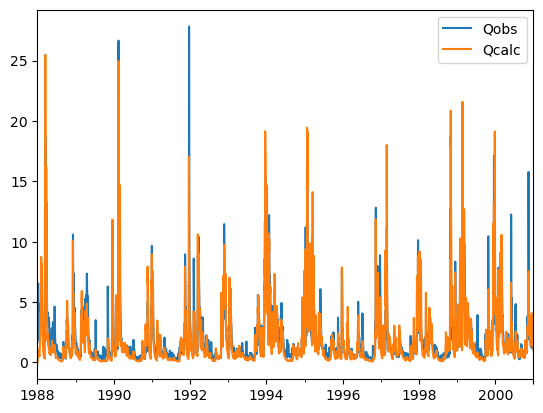

In [420]:
Qtimeseries.plot()

<Axes: >

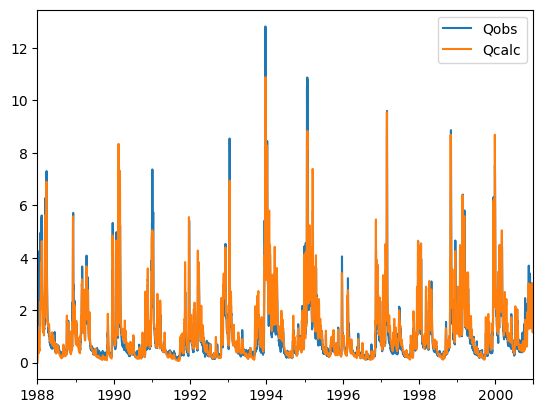

In [242]:
Qtimeseries.plot()

<Axes: >

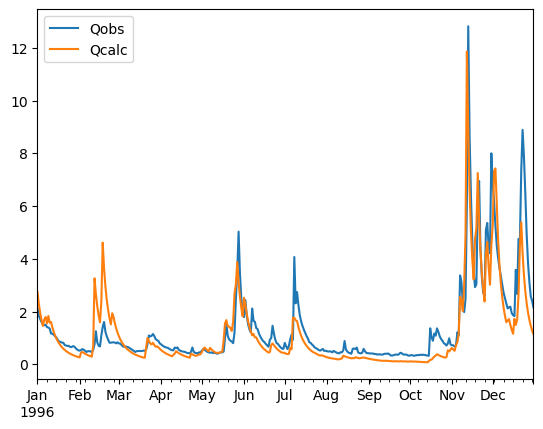

In [421]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

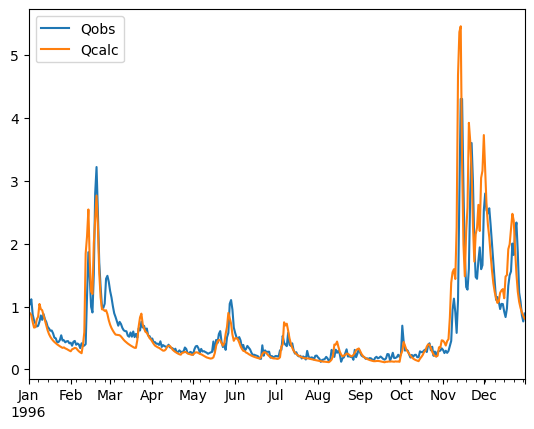

In [243]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

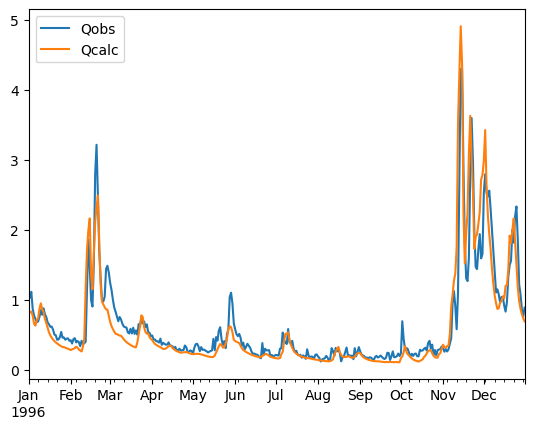

In [217]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

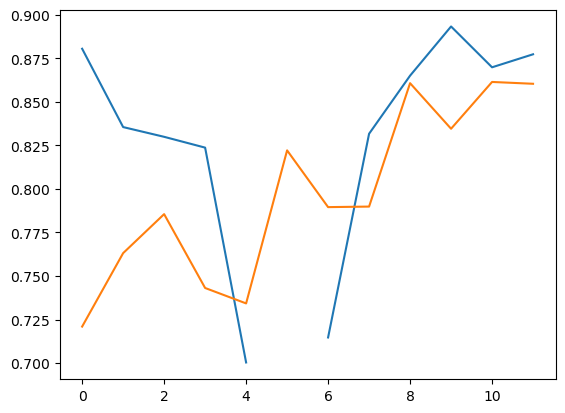

In [ ]:
nse_results_cal.nse.plot()
nse_df.nse.plot()

In [849]:
# Create an empty list to store results
nse_results_teste = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results_teste.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_teste = pd.DataFrame(nse_results_teste)
nse_df_teste

,gauge_name,basin,nse,q_mean_obs,q_mean_calc
0,Pruem,DERP2006,0.704425,1.366707,1.191072
1,Reuland,BEWA0106,0.658036,0.986279,1.011901
2,La Cleurie Ã Cleurie,FR003234,0.486500,2.880037,1.996820
3,La Meurthe Ã Fraize,FR003250,0.119606,2.136579,1.576757
4,A4020610,FR000124,0.746570,3.559682,2.936508
5,Saarburg,DERP2016,0.496545,0.784706,0.868912
6,Schoenfels,LU000018,0.488135,0.868880,0.940222
7,L'Horn Ã Bousseviller,FR003303,-1.226996,0.580874,0.957351
8,Sinspelt,DERP2008,0.713991,0.917357,0.938009
9,Hentern,DERP2017,0.724704,1.184664,1.127147


<Axes: >

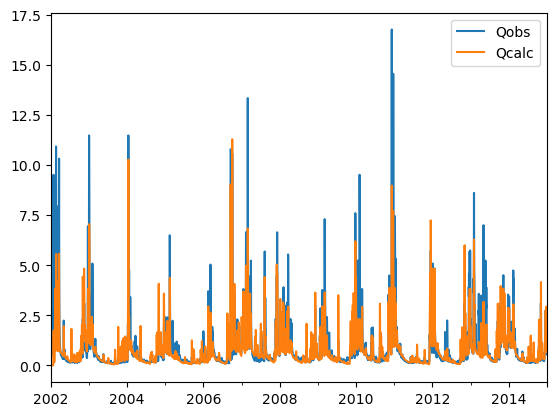

<Axes: >

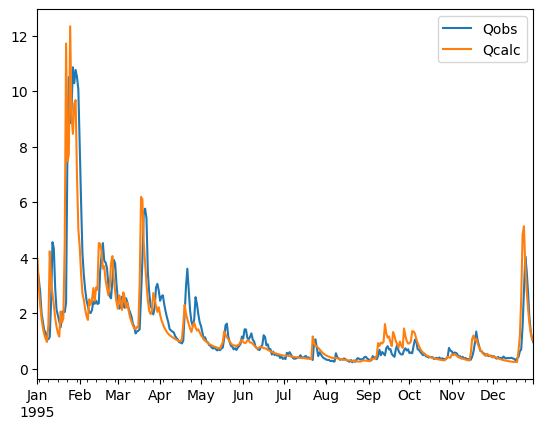

In [298]:
for basin in areas.keys():
    Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    print(basin, 1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))

FR003237 0.7233558713807696
FR003249 0.7857027176186224
FR003253 0.3878544582627701
FR000159 0.6081680596664203
FR003265 0.7132547232230247
FR003271 0.6637390250040114
FR000171 0.6953316970346151
FR003272 0.691946589157379
FR003283 0.7316089827911934
FR003275 0.7009760159437041
DEBU1956 0.6757108948721947
DEBU1957 0.7483438095953565
FR003308 0.7618494373966822
FR003301 0.7811255177666672
FR003304 0.449355969739905
LU000007 0.7332146572606155
DERP2004 0.7649510673714486
DERP2017 0.6359296340769447
DEBU1958 0.7089337378169949
DERP2024 0.6272714335495646
DERP2033 0.7550015470091432
DEBU1959 0.685422176404427
DERP2011 0.7589612835549371
DERP2003 0.7608982082514891
DERP2007 0.7282897928315735


In [292]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2033"]
Qtimeseries["Qcalc"] = output["DERP2033"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

ValueError: Length of values (4748) does not match length of index (4749)

<Axes: >

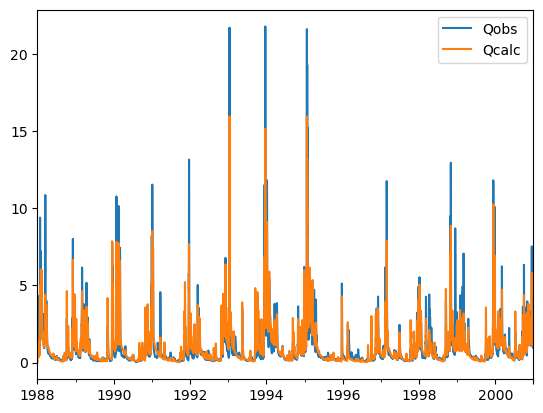

In [310]:
Qtimeseries.plot()

In [301]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003237"]
Qtimeseries["Qcalc"] = output["FR003237"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7233558713807696

<Axes: >

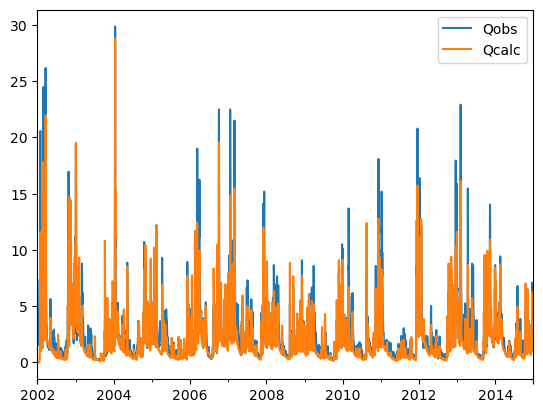

In [302]:
Qtimeseries.plot()

In [234]:
areas

{'FR003237': 1218.14,
 'DERP2004': 615.0,
 'FR003253': 1102.95,
 'FR003249': 3396.832,
 'LU000007': 1115.773}

In [286]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003249"]
Qtimeseries["Qcalc"] = output["FR003249"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7976164883940482

<Axes: >

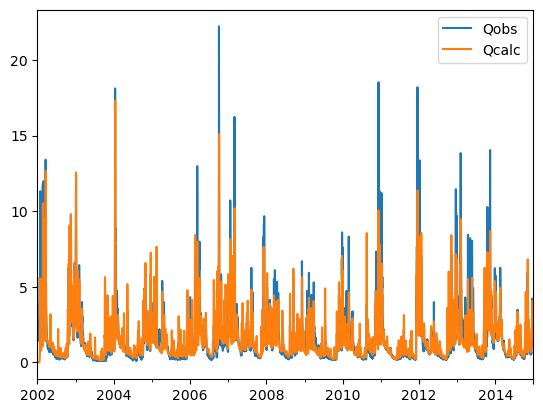

In [287]:
Qtimeseries.plot()

In [288]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.54352649657022

In [289]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.6551187507433864

0.7380498663278228


<Axes: >

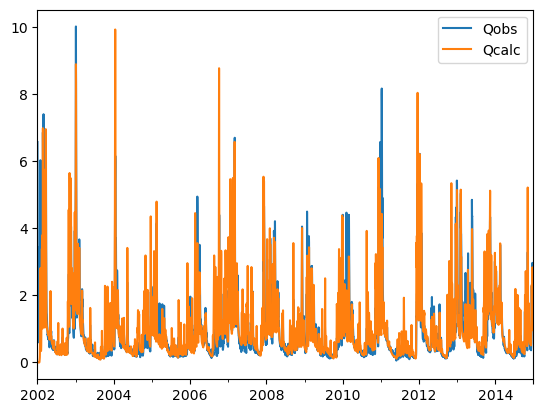

In [292]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

print(1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))
Qtimeseries.plot()

In [187]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


best_params_dict['M4_lowersplitter_split-par'] = 0.65


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output

{'FR003237': [array([0.        , 0.        , 0.        , ..., 1.57438332, 1.47980825,
         1.41788529])],
 'DERP2004': [array([0.        , 0.        , 0.        , ..., 1.9179584 , 1.57526105,
         1.32558672])],
 'FR003253': [array([0.        , 0.        , 0.        , ..., 1.02099612, 1.13402406,
         1.01305816])],
 'DERP2007': [array([0.        , 0.        , 0.        , ..., 1.64363308, 1.36571395,
         1.15799314])],
 'LU000007': [array([0.        , 0.        , 0.        , ..., 1.6860886 , 1.29039931,
         1.13582222])]}

In [188]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.29667524112089794

In [185]:
estreams_attributes.loc["FR003253", "baseflow_index"]

0.642

In [186]:
areas

{'FR003237': 1218.14,
 'DERP2004': 615.0,
 'FR003253': 1102.95,
 'DERP2007': 576.0,
 'LU000007': 1115.773}

In [180]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.29667524112089794

In [181]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2007"]
Qtimeseries["Qcalc"] = output["DERP2007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.4073419927466919

In [182]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7330260915554658

In [122]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0107"]
Qtimeseries["Qcalc"] = output["BEWA0107"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

KeyError: 'BEWA0107'

In [123]:
Qtimeseries.plot()

TypeError: no numeric data to plot

In [ ]:



best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])


In [101]:
results[bestindex]

(0.21799583, 0.26215353, 0.03040796, 1.04298502, 0.30325854, 4.89524188, 0.54104064, 2.96090588, 0., 0., 0., 0., 0., 0., 3.22830274e-09, 3.22830315e-09, 3.22830484e-09, 3.22830484e-09, 3.22830484e-09, 4.83473582e-09, 9.26305152e-09, 9.26305704e-09, 9.26306495e-09, 2.46473382e-07, 2.39202513e-07, 8.67886741e-06, 0.00025929, 0.00404235, 0.0062661, 0.01236216, 0.03278941, 0.1079614, 0.29851124, 1.01452128, 2.670107, 5.14868331, 5.2868262, 2.81678834, 1.59637771, 1.20727177, 1.05250243, 0.91586989, 0.81070585, 0.92893766, 1.27789203, 1.8606845, 2.2005742, 3.47513916, 4.78386541, 6.50633744, 6.62457777, 8.85677967, 9.48615831, 5.56301823, 3.07196287, 2.26184297, 2.09884728, 3.12060445, 6.22657207, 9.48440121, 8.1368917, 5.22019468, 5.7498476, 6.6664143, 8.29846701, 9.32693118, 7.47366003, 4.74975664, 3.63532758, 2.98653908, 2.66623446, 2.47873928, 2.41831956, 2.4250216, 2.48349846, 2.3148532, 2.16848808, 2.0610354, 1.96877264, 1.91439893, 1.95823485, 2.06843085, 2.17012699, 1.94399276, 1.99

In [ ]:



import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):
        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            catchments (list): List of Node objects.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._catchments = catchments  # Use predefined catchments list
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the simulation for all nodes using the same parameter set."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        outputs = {}  # Store simulation results for each node

        for cat in self._catchments:  # Iterate over manually defined catchments
            cat.set_parameters(named_parameters)  # Apply shared parameters

            # Generate input data
            P = np.zeros(100)
            P[:10] = np.random.randint(10, size=10)
            P[25:30] = np.random.randint(20, size=5)
            P[40:60] = np.random.randint(5, size=20)
            P[80:83] = np.random.randint(30, 50, size=3)

            E = np.ones_like(P) * 2.0  # Constant PET
            T = (np.random.rand(100) - 0.2) * 20  # Random Temperature

            cat.set_input([P, T, E])  # Directly set input for each node
            cat.set_timestep(self._dt)
            cat.reset_states()  # Reset internal states

            output = cat.get_output()
            outputs[cat.id] = output[self._output_index]  # Store results for each node

        return outputs  # Dictionary with outputs for each node

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for node_id in simulation.keys():
            # Apply warm-up period
            sim = simulation[node_id][self._warm_up + 1:]
            obs = evaluation[node_id][self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error


In [70]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [71]:
DERP2004.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=DERP2004,
    inputs=[P, T, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        #spotpy.parameter.Uniform('M4_snow_k', 0.0, 1.0),

    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'], #"M4_snow_k"
    output_index=0
)

In [72]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=100)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 100, minimal objective function=0.565567, time remaining: 00:03:14
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
47 of 100, minimal objective function=0.312685, time remaining: 00:00:06
93 of 100, minimal objective function=0.306699, time remaining: 00:00:01
Stopping samplig. Maximum number of repetitions reached already during burn-in
Burn-in sampling completed...
*** OPTIMIZATION SEARCH TERMINATED BECAUSE THE LIMIT
ON THE MAXIMUM NUMBER OF TRIALS 
100
HAS BEEN EXCEEDED.  SEARCH WAS STOPPED AT TRIAL NUMBER:
100
OF THE INITIAL LOOP!
Starting Complex Evolution...
SEARCH WAS STOPPED AT TRIAL NUMBER: 100
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.995276
THE BEST POINT HAS IMPROVED IN LAST 100 LOOPS BY 100000.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 8.34 seconds
Tot

The figure as been saved as "Parameter_trace.png
Run number 2035 has the lowest objectivefunction with: 0.202


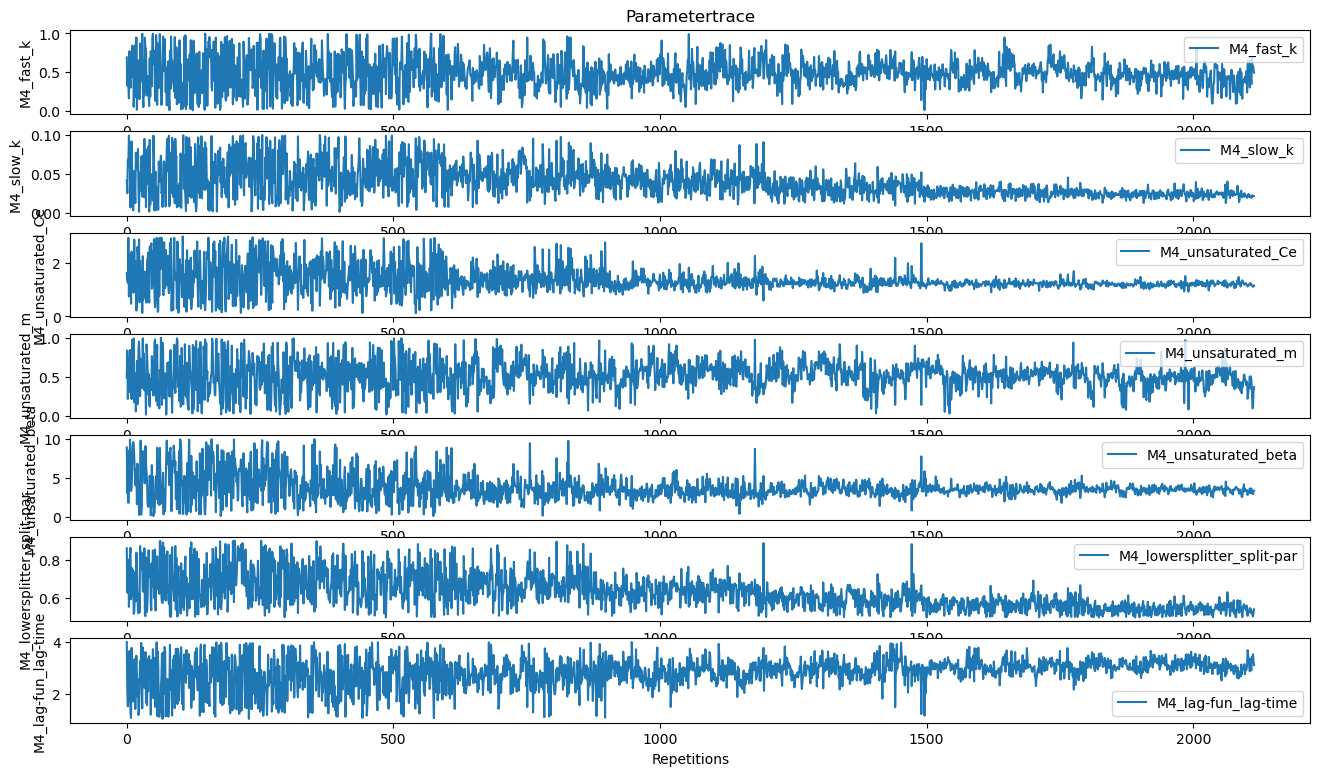

In [622]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [623]:
best_model_run

(0.20200061, 0.12008787, 0.0198779, 1.22223028, 0.39998824, 3.19294541, 0.51119517, 3.0028395, 0., 0., 0., 0., 0., 0., 3.54544801e-08, 3.47635228e-08, 3.40862573e-08, 3.34219086e-08, 3.2770507e-08, 5.21709113e-08, 1.08241492e-07, 1.06132973e-07, 1.04066199e-07, 3.37398075e-06, 3.30886324e-06, 8.88586634e-05, 0.00125214, 0.00929014, 0.01743471, 0.04064369, 0.07508837, 0.17258437, 0.39702485, 1.00007245, 2.30194319, 4.51820682, 4.97038484, 2.9338087, 1.72997976, 1.261859, 1.05027737, 0.88472904, 0.75497195, 0.81379401, 1.08079594, 1.55596908, 1.86087039, 2.91158524, 4.13663756, 5.86325392, 6.08912922, 8.20314217, 9.15761393, 5.65865208, 3.11695368, 2.15255576, 1.85928087, 2.58365745, 5.2096476, 8.5270946, 7.75610952, 5.02709266, 5.29747893, 6.00473094, 7.47724821, 8.64316058, 7.13361208, 4.5425116, 3.33914416, 2.61832611, 2.25067126, 2.04148448, 1.96606056, 1.97513781, 2.04646186, 1.91202072, 1.79043339, 1.7035145, 1.63032868, 1.59239431, 1.63681642, 1.75182816, 1.86531227, 1.69845856, 1

In [624]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

0.7985578052913354

In [625]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.6466534156753938

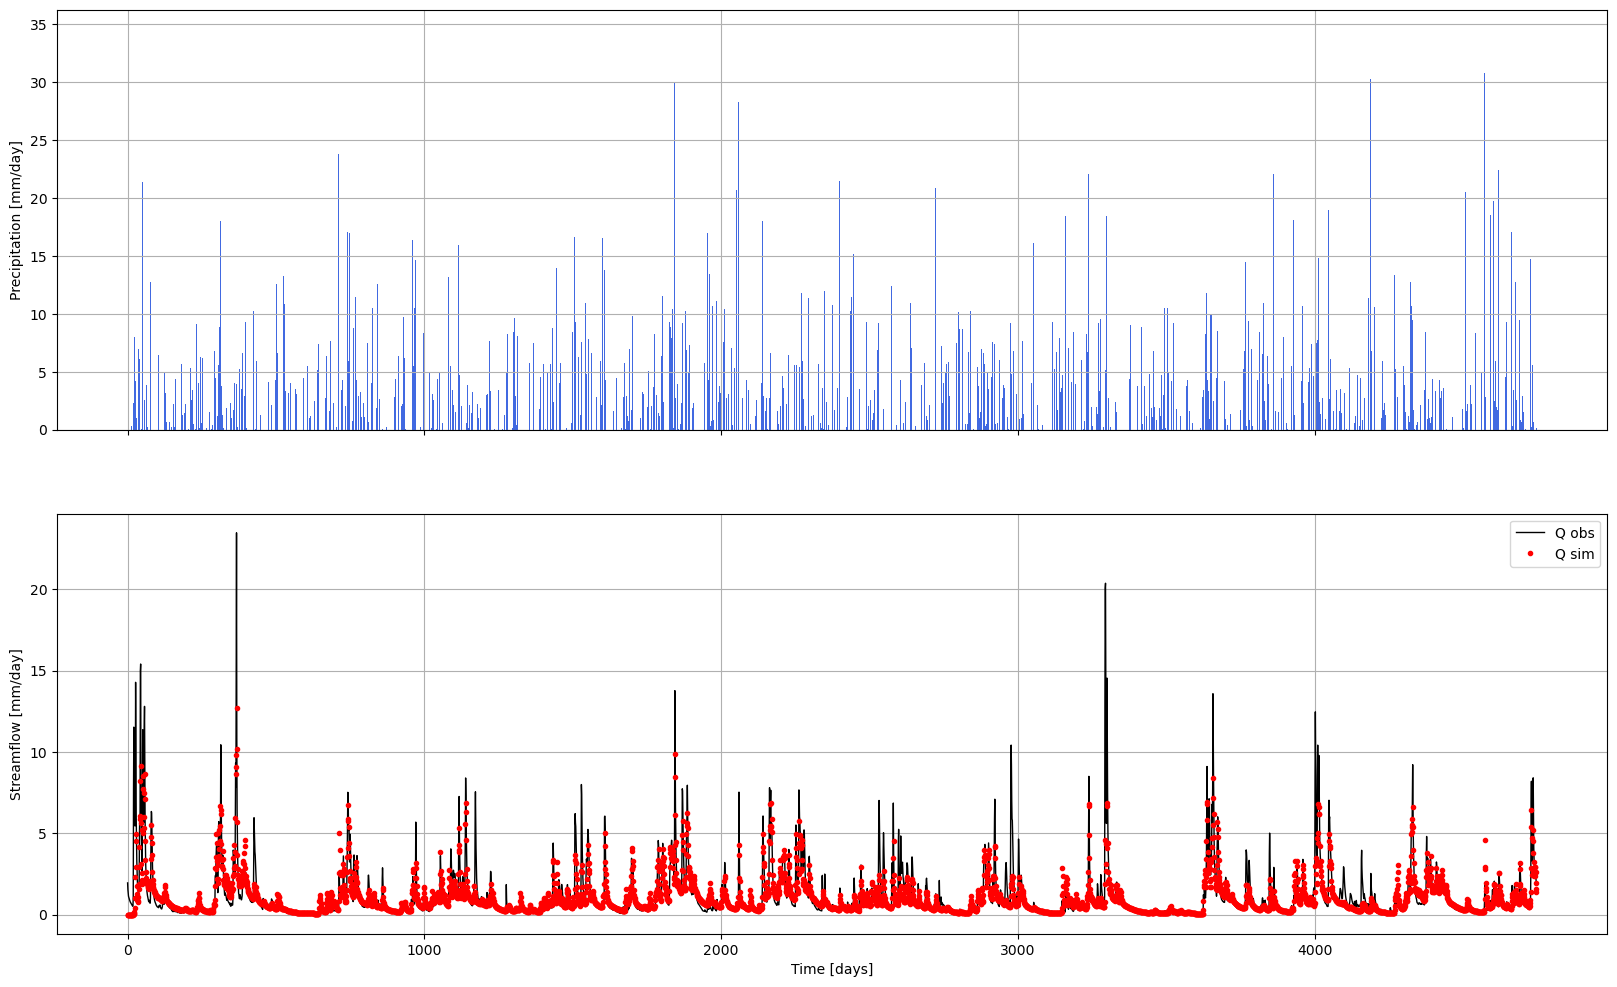

In [626]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [627]:
best_params_dict

{'M4_fast_k': 0.1200878726168807,
 'M4_slow_k': 0.0198778976594689,
 'M4_unsaturated_Ce': 1.2222302759799968,
 'M4_unsaturated_m': 0.39998823861160615,
 'M4_unsaturated_beta': 3.1929454065223943,
 'M4_lowersplitter_split-par': 0.5111951674708165,
 'M4_lag-fun_lag-time': 3.0028394978328286}

In [637]:
#best_params_dict['M4_lowersplitter_split-par'] = 0.5
best_params_dict['M4_fast_k'] = 1.0
#best_params_dict['M4_slow_k'] = 0.01
#best_params_dict['M4_snow_k'] = 0.01
#best_params_dict['M4_lag-fun_lag-time'] = 3.0
#best_params_dict['M4_unsaturated_beta'] = 5.0

In [638]:
hyd_mod.reset_states()
hyd_mod.set_input([P,T, E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

[array([0.        , 0.        , 0.        , ..., 1.53705382, 1.24153621,
        1.12653391])]

In [639]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

,Qobs,Qcalc
2002-01-01,1.950238,0.000000
2002-01-02,1.534647,0.000000
2002-01-03,1.293373,0.000000
2002-01-04,1.131966,0.000000
2002-01-05,1.063647,0.000000
...,...,...
2014-12-27,2.787952,3.007358
2014-12-28,2.714421,2.524129
2014-12-29,2.269552,1.537054
2014-12-30,2.025230,1.241536


In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2001', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

ValueError: Length of values (4748) does not match length of index (5113)

In [640]:
data_comparation = Qtimeseries.copy()

data_comparation

,Qobs,Qcalc
2002-01-01,1.950238,0.000000
2002-01-02,1.534647,0.000000
2002-01-03,1.293373,0.000000
2002-01-04,1.131966,0.000000
2002-01-05,1.063647,0.000000
...,...,...
2014-12-27,2.787952,3.007358
2014-12-28,2.714421,2.524129
2014-12-29,2.269552,1.537054
2014-12-30,2.025230,1.241536


ValueError: zero-size array to reduction operation fmin which has no identity

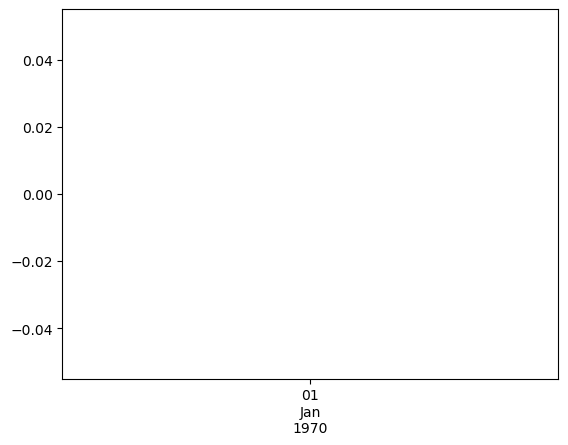

In [641]:
data_comparation.loc["1995-02-01":"1995-06-01"].plot()

<Axes: >

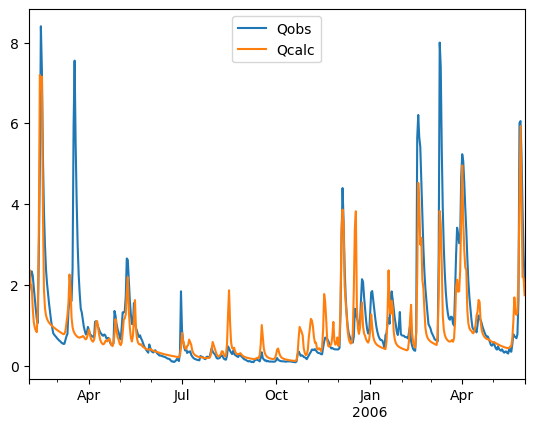

In [642]:
data_comparation.loc["2005-02-01":"2006-06-01"].plot()

In [643]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7803191635265792

In [644]:
network_estreams.loc[basin_id, :]

gauge_id                                                      2626030300
gauge_name                                                    GemuendOur
gauge_country                                                         DE
gauge_provider                                                     DE_RP
river                                                                Our
lon_snap                                                           6.171
lat_snap                                                          49.985
lon                                                                6.171
lat                                                               49.985
elevation                                                            NaN
area_official                                                      613.4
area_estreams                                                      615.0
area_flag                                                              0
area_rel                                           